## Dependencies

In [53]:
import os
import shutil
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import calendar
import missingno as msno
import time
import datetime
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from IPython.display import Image
tqdm.pandas()

In [4]:
plt.style.use("seaborn")

#### some boilerplate code has been kept in rfd custom module to keep notebook short and reacable, please refer to rfd for source code or use "?" with function/class to see the docstring 

### Custom Module imports

In [35]:
from rfd.utility import autolabel, month_year_iter, get_random_rgb
from rfd.NLP_features import numerical_features, pos_features
from rfd.Preprocess import clean_text
from rfd.TextPreprocessor import TextPreprocessor

#### Reading the data
- Reading the csv files as per the calendar combine them into single dataframe(or file), files names are pretty much self explanatory
- Later we can read sigle combined df 

In [6]:
df_1 = pd.read_csv("../data/Submissions-Jan-2019.csv")
df_2 = pd.read_csv("../data/Submissions-Feb-2019.csv")
df_3 = pd.read_csv("../data/Submissions-March-2019.csv")
df_4 = pd.read_csv("../data/Submissions-April-2019.csv")
df_5 = pd.read_csv("../data/Submissions-May-2019.csv")
df_6 = pd.read_csv("../data/Submissions-June-2019.csv")
df_7 = pd.read_csv("../data/Submissions-July-2019.csv")
df_8 = pd.read_csv("../data/Submissions-Aug-2019.csv")
df_9 = pd.read_csv("../data/Submissions-Sep-2019.csv")
df_10 = pd.read_csv("../data/Submissions-Oct-2019.csv")
df_11 = pd.read_csv("../data/Submissions-Nov-2019.csv")
df_12 = pd.read_csv("../data/Submissions-Dec-2019.csv")
df_13 = pd.read_csv("../data/Submissions-Jan-2020.csv")
df_14 = pd.read_csv("../data/Submissions-Feb-2020.csv")
df_15 = pd.read_csv("../data/SubmissionS-March-2020.csv")

- a combined dataframe is created and stored in Submissions-Jan-2019-to-March-2020.csv in dataframes subdir read that file instead

In [7]:
# List of dataframes
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14, df_15]

In [8]:
print(len(dfs))

15


m### Submission Distribution over Month

In [8]:
monthly_submissions = {}
for year, month, df in month_year_iter(1, 2019, 4, 2020, dfs):
    monthly_submissions[str(calendar.month_name[month])+" "+str(year)] = df.shape[0]


-  We mightneed monthly submission into our web app visualization so lets dump the dict into json file


In [9]:
# with open("monthly_submission.json", 'w') as fp:
#     json.dump(monthly_submissions, fp)

In [10]:
# get the months and submissions from monthly_submissions dictionary{}
months = list(monthly_submissions.keys())
submissions = list(monthly_submissions.values())

#### Monthly Submission Plot

In [97]:
# num of istances
print(len(submissions), len(months))

# monthly submissions
plt.figure(figsize=(24, 8))
# fig, ax = plt.subplots()
ax = sns.barplot(x=months, y=submissions)

# set the bar height as bar value
utility.autolabel(ax, dtype=float)
ax.set_xticklabels(months, rotation=45)
utility.change_width(ax, 0.7)
plt.title("Monthly Submissions(March 2020 have submissions upto April 10, 2020)", fontdict={"fontsize":20})
plt.xlabel("Submissions", fontdict={"fontsize":16})
plt.xlabel("Months", fontdict={"fontsize":16})
# plt.savefig("monthly_submission.png")
plt.show()

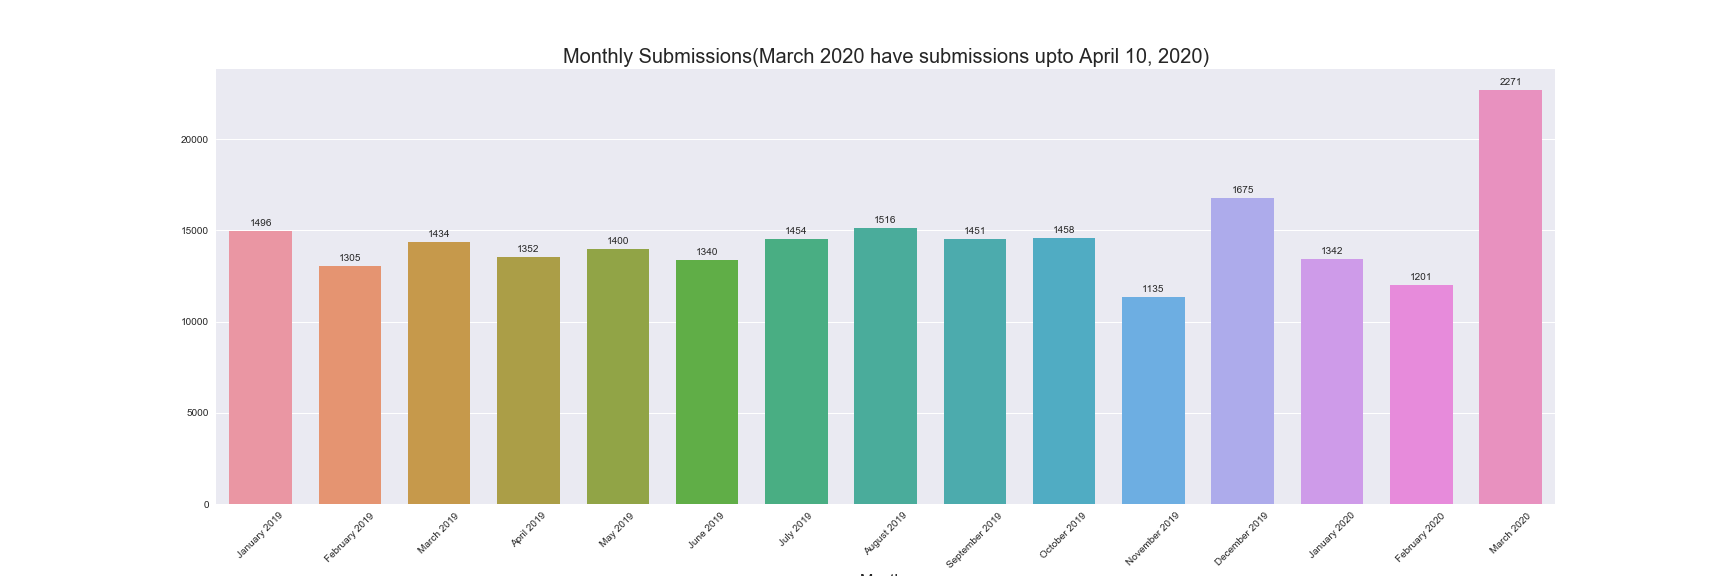

In [98]:
Image("assets/monthly_submission.png")

In [12]:
####  Nothing much ! I thought due to Covid19 outbreak we can see a spike in monthly submissions

In [9]:
# Concatenate all the Dataframes
df = pd.concat(dfs)

- Writing the combined data into a csv files(We might need it later) this is one time executable script hence commenting it after execution

In [14]:
# df.to_csv("Submissions-Jan-2019-to-March-2020.csv", index=False)

In [15]:
# Combined datafram info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218370 entries, 0 to 22709
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   allow_live_comments      134036 non-null  object 
 1   author                   218370 non-null  object 
 2   author_premium           63303 non-null   object 
 3   can_mod_post             218370 non-null  bool   
 4   contest_mode             218370 non-null  bool   
 5   created_utc              218370 non-null  int64  
 6   full_link                218370 non-null  object 
 7   id                       218370 non-null  object 
 8   is_crosspostable         218370 non-null  bool   
 9   is_meta                  218370 non-null  bool   
 10  is_original_content      218370 non-null  bool   
 11  is_self                  218370 non-null  bool   
 12  is_video                 218370 non-null  bool   
 13  link_flair_text          117692 non-null  object 
 14  locke

- It looks like plently of properties have null values lets visualise the above info into graphs

#### Missing Values bar plot

In [100]:
%%time
plt.figure(figsize=(24, 8))
msno.matrix(df)
plt.title("Missing Values", fontdict={"fontsize":20})
plt.xlabel("Submission Properties", fontdict={"fontsize":16})
plt.ylabel("Count", fontdict={"fontsize":16})
plt.savefig("assets/missing_values_matrix.png")
plt.show()

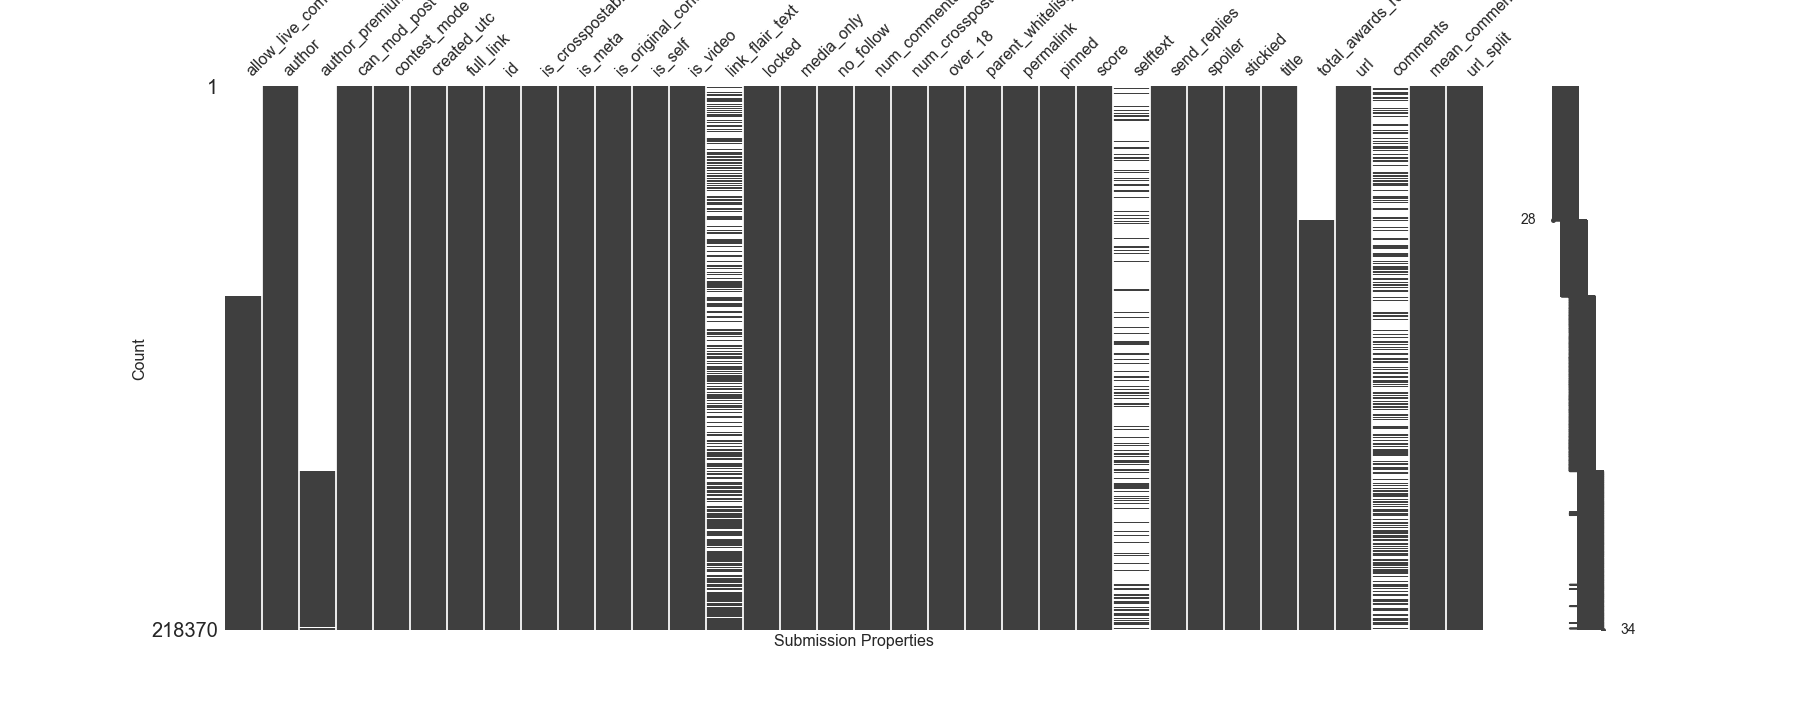

In [101]:
Image("assets/missing_values_matrix.png")

##### Note:
- link_flair_text = flair (target variable)
- self_text = submission(post) body

#### **Inference**
- Total Entries = 218370
- In the missing plot we can see that there are many missing dependent and independent variables
- Such as allo_live_comments author_premium, link_flair_text, self_text, total_awards_received, comments
- There are lots of submissions whose target variable(flair) is missing either we have to drop those entries or we need to immpute them,  we will catch them later.

In [18]:
#### Bar plot of missing values | exactly how many values are missinng in each coloumn

In [102]:
msno.bar(df); # This graph is a visual interpretation of df.info()
plt.title("Missing Values Barplot", fontdict={"fontsize":20})
plt.xlabel("Submission Properties", fontdict={"fontsize":16})
plt.ylabel("Count(%)", fontdict={"fontsize":16})
plt.show()

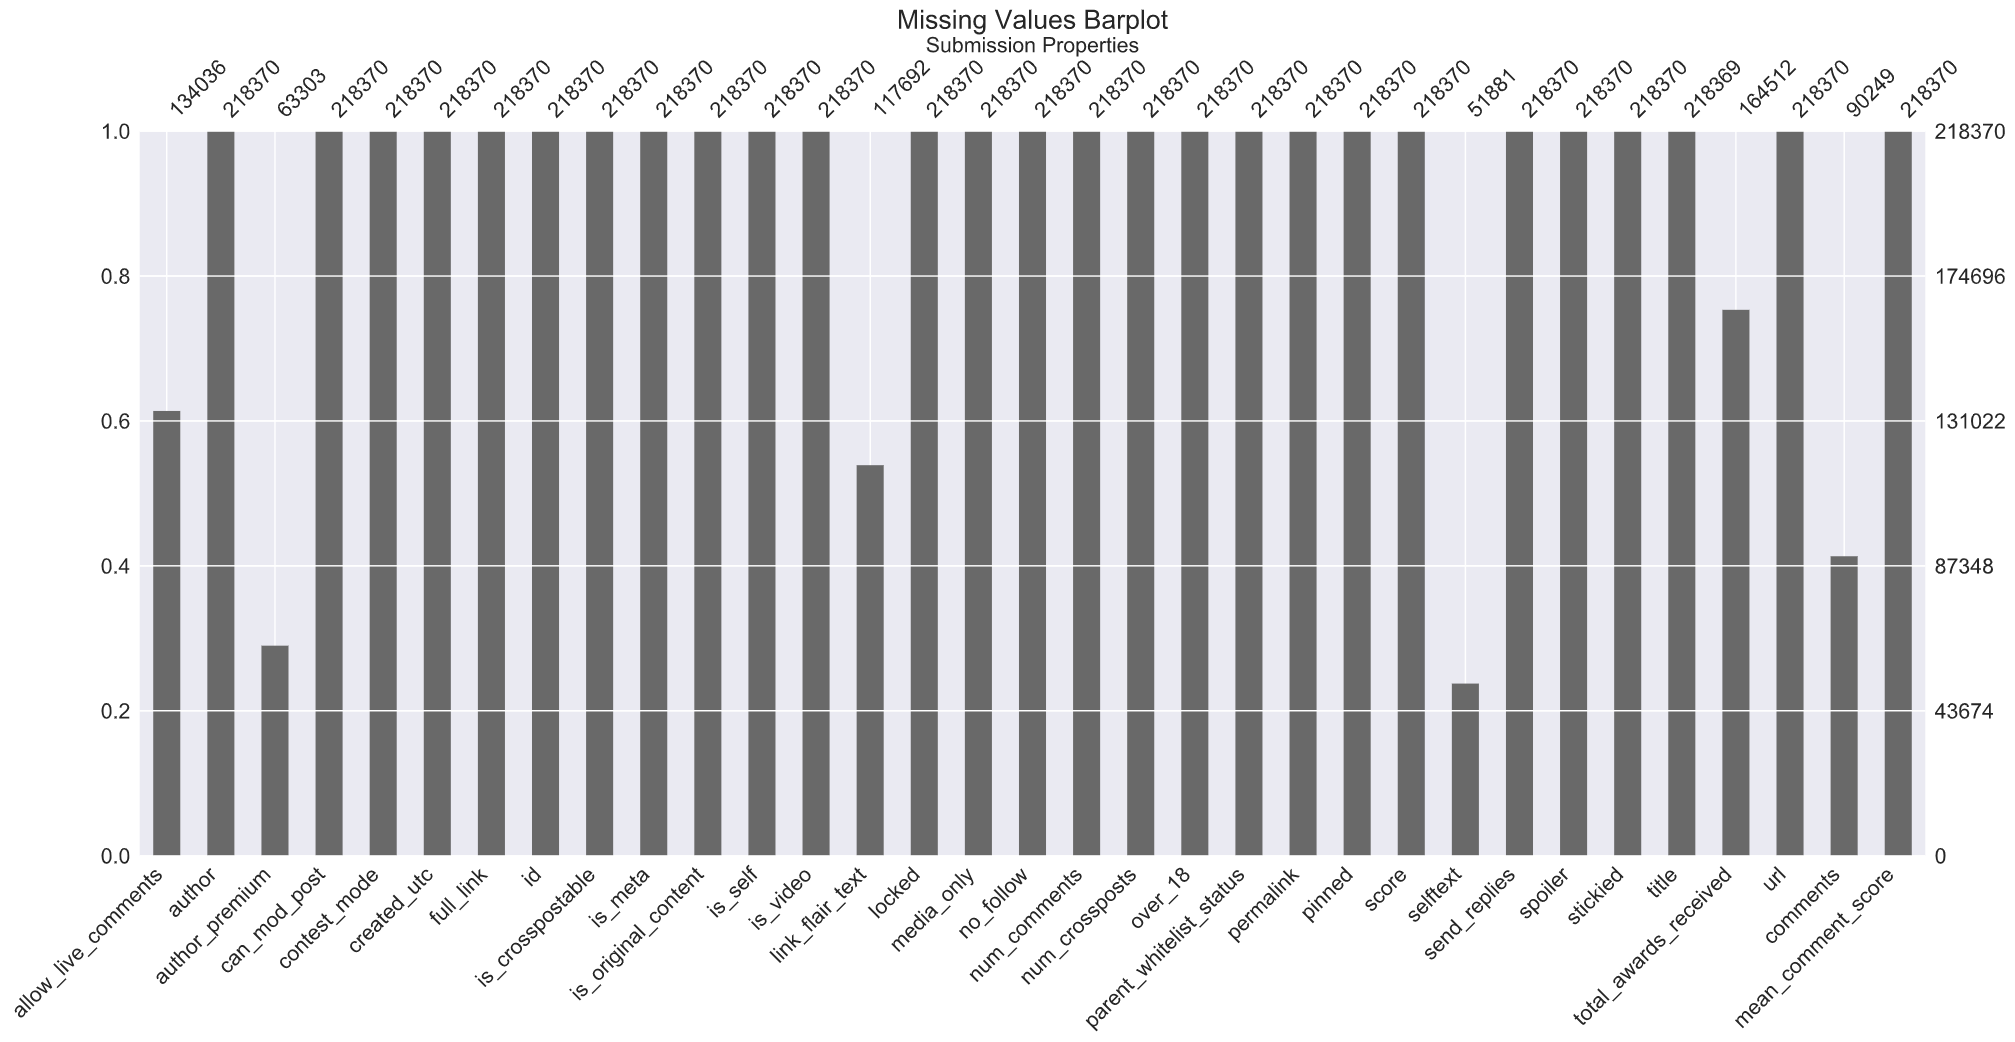

In [103]:
Image("assets/missing_barplot.png")

#### **Inference**
- link_flair_text (flair) is dependent variable(target variable) and ~50% of submissions have no flair hence either I need to drop them or impute them 
- There are multiple cols which ~ >=60% missing
- Less than 1/4th of total submissions have body and nearly 40% submissions at least 1 comment

### Flair Distribution

In [16]:
# Get the list of flairs and corresponding frequency 
flairs_df = df.link_flair_text
flairs_df = flairs_df.fillna("Miscellaneous")
flairs, freq = np.unique(flairs_df.values, return_counts=True)

In [17]:
flairs_freq = dict(zip(flairs, freq))

In [18]:
print(flairs_freq)

{'AMA': 5, 'AMA Announcement': 2, 'All CAPS.': 752, 'Announcement': 2, 'AskIndia': 18343, 'Aug 2019 - Politics': 1, 'Business/Finance': 7277, 'CAA-NRC': 1024, 'CAA-NRC-NPR': 76, 'Casual AMA': 1, 'Coronavirus': 6757, 'Dead Link': 1, 'Demonetization': 780, 'Food': 1511, 'Foodpolitics': 1, 'Low Quality/Non OC Meme': 20, 'Low-effort self-post.': 541, 'Megathread': 1, 'Meta': 1, 'Meta.': 11, 'Meta. | Custom (Informed OP) |': 1, 'Miscellaneous': 100678, 'Non-Political': 27806, 'Not Appropriate Subreddit': 4, 'Not in English.': 657, 'PARTAYYY AGAIN :D': 1, 'Personal/Unverified Twitter.': 5, 'Photography': 3406, 'Policy/Economy': 4875, 'Politics': 32229, 'Post link Directly': 4, 'Scheduled': 693, 'Science &amp; Technology': 7, 'Science/Technology': 5346, 'Shitpost': 9, 'Sports': 1992, 'Unverified': 4, 'Verified': 1, '[R]eddiquette': 3335, '| Custom (Informed OP) |': 4, '| Image Rule Violation |': 8, '| Low-effort Self Post |': 25, '| Low-effort Self Post | Post link Directly': 1, '| Low-effort

In [19]:
print(f'total number of unique flair {len(flairs_freq)}')

total number of unique flair 64


#### Reddit submissions are real time data and we can see that it is highly imbalanced and imputation of target variable will lead to more data imablance, also imputing dependent variable is considered as bad practice, hence droping them is only good option for now

#### Downsampling the dataset based on total submission in a flair to reduce the data imbalance. There are many redundant flairs and semantically vague flairs which should be removed. I will remove those instances which have not a threshold number of samples. Morever there are some flairs which have no meaning like "Not in English", "ALL CAPS", "Scheduled" to remove such instances we have to choose right threshold value or we may require to remove them manually
[23]



In [20]:
df_no_missing_flairs = df.dropna(subset=['link_flair_text'])
print(f"Dropped {flairs_freq.get('Miscellaneous')} entries ")
# delete it from flair dictionary as well
del flairs_freq['Miscellaneous']

Dropped 100678 entries 


In [21]:
thresh = 1500 # If a falir has less thresh samples I will remove it.
flairs_freq_downsampled = dict((key, value) for key, value in flairs_freq.items() if value > thresh )

In [22]:
# print how many valid flairs and total number of submission satisfying the criteria
print(f'total valid flairs :{len(flairs_freq_downsampled.keys())} \n total samples = {sum(flairs_freq_downsampled.values())}')
flairs_freq_downsampled

total valid flairs :11 
 total samples = 112877


{'AskIndia': 18343,
 'Business/Finance': 7277,
 'Coronavirus': 6757,
 'Food': 1511,
 'Non-Political': 27806,
 'Photography': 3406,
 'Policy/Economy': 4875,
 'Politics': 32229,
 'Science/Technology': 5346,
 'Sports': 1992,
 '[R]eddiquette': 3335}

In [23]:
# drop the index
df_no_missing_flairs.reset_index(drop=True, inplace=True)

In [24]:
df_no_missing_flairs.shape

(117692, 33)

In [25]:
# get the index of all submissions to remove
index = []
for row in tqdm(range(df_no_missing_flairs.shape[0])):
    if df_no_missing_flairs.link_flair_text.values[row] not in list(flairs_freq_downsampled.keys()):
        index.append(row)

100%|██████████| 117692/117692 [00:00<00:00, 150458.70it/s]


In [26]:
# drop them by indices
new_df = df_no_missing_flairs.drop(index)

### Submission Distribution over time

#### Hourly Submissions

In [27]:
new_df['hour'] = new_df.created_utc.apply(lambda x : datetime.datetime.fromtimestamp(x).hour)
new_df['day'] = new_df.created_utc.apply(lambda x : datetime.datetime.fromtimestamp(x).day)

In [108]:
%%time
"""
    Hourly submissions in r/india 
"""
plt.figure(figsize=(24, 8))
ax = sns.lineplot(data=new_df.link_flair_text.groupby(new_df.hour).count(), marker="o")

# Interactive plot
# new_df.link_flair_text.groupby(new_df.hour).count().iplot(
#     title="Hourly Submission in r/india",
#     xTitle="TIME IST",
#     yTitle="Submissions"
# )

plt.title("Hourly Submissions in r/india subreddit", fontdict={"fontsize":20})
plt.xlabel("IST Time", fontdict={"fontsize":16})
plt.ylabel("Submissions", fontdict={"fontsize":16})
plt.axis("tight")
plt.show()

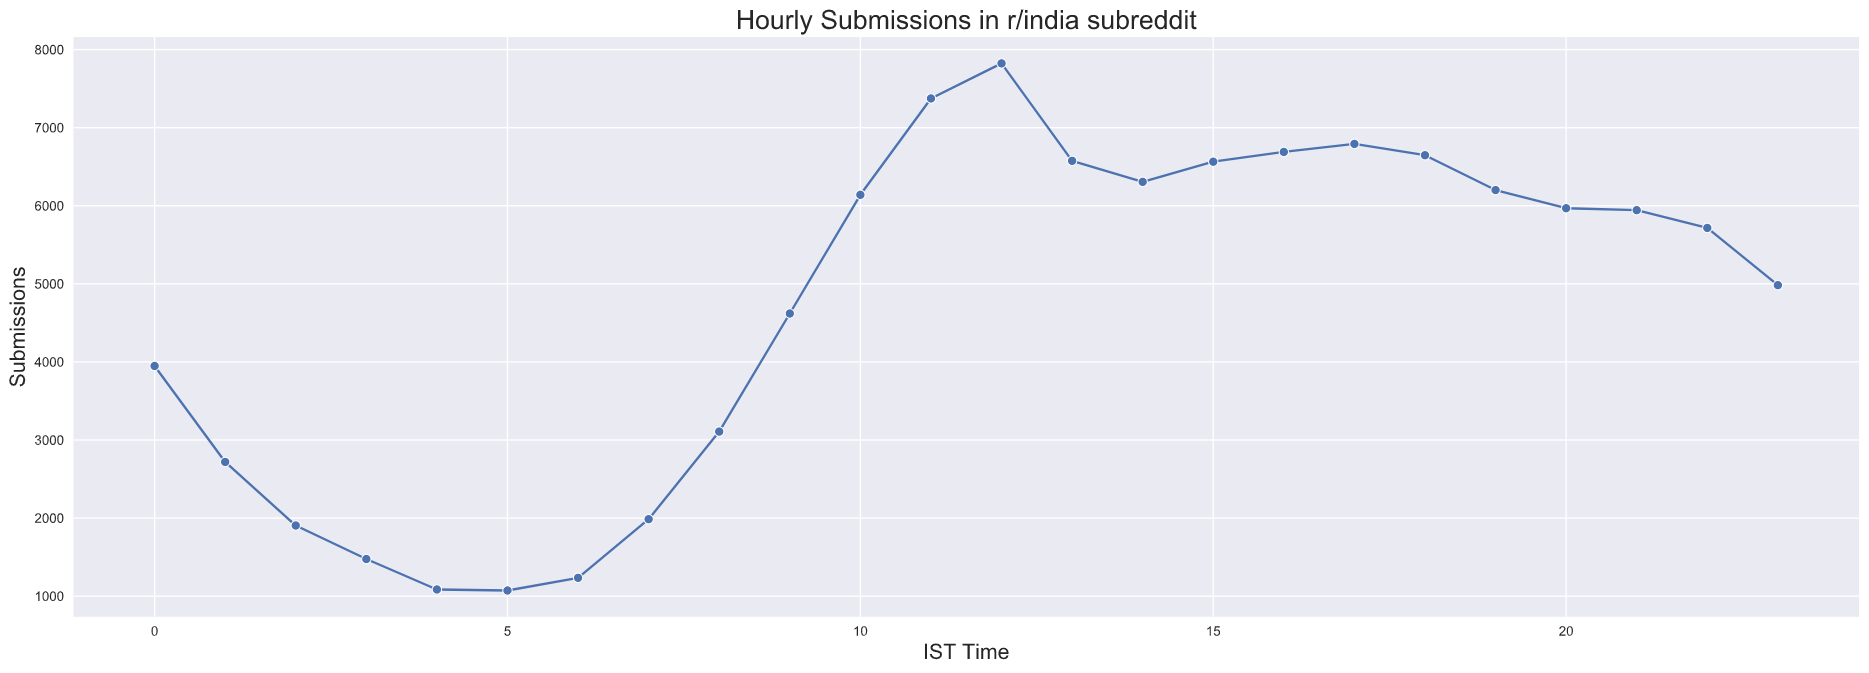

In [109]:
Image("assets/hourly_submission.png")

#### Daily Submission

In [107]:
%%time
"""
    Daily submissions in r/india 
"""
plt.figure(figsize=(24, 8))
ax = sns.lineplot(data=new_df.link_flair_text.groupby(new_df.day).count(), marker="o")

# Interactive plot
# new_df.link_flair_text.groupby(new_df.hour).count().iplot(
#     title="Hourly Submission in r/india",
#     xTitle="TIME IST",
#     yTitle="Submissions"
# )

plt.title("Daily Submissions in r/india subreddit", fontdict={"fontsize":20})
plt.xlabel("Day", fontdict={"fontsize":16})
plt.ylabel("Submissions", fontdict={"fontsize":16})
plt.axis("tight")
plt.show()

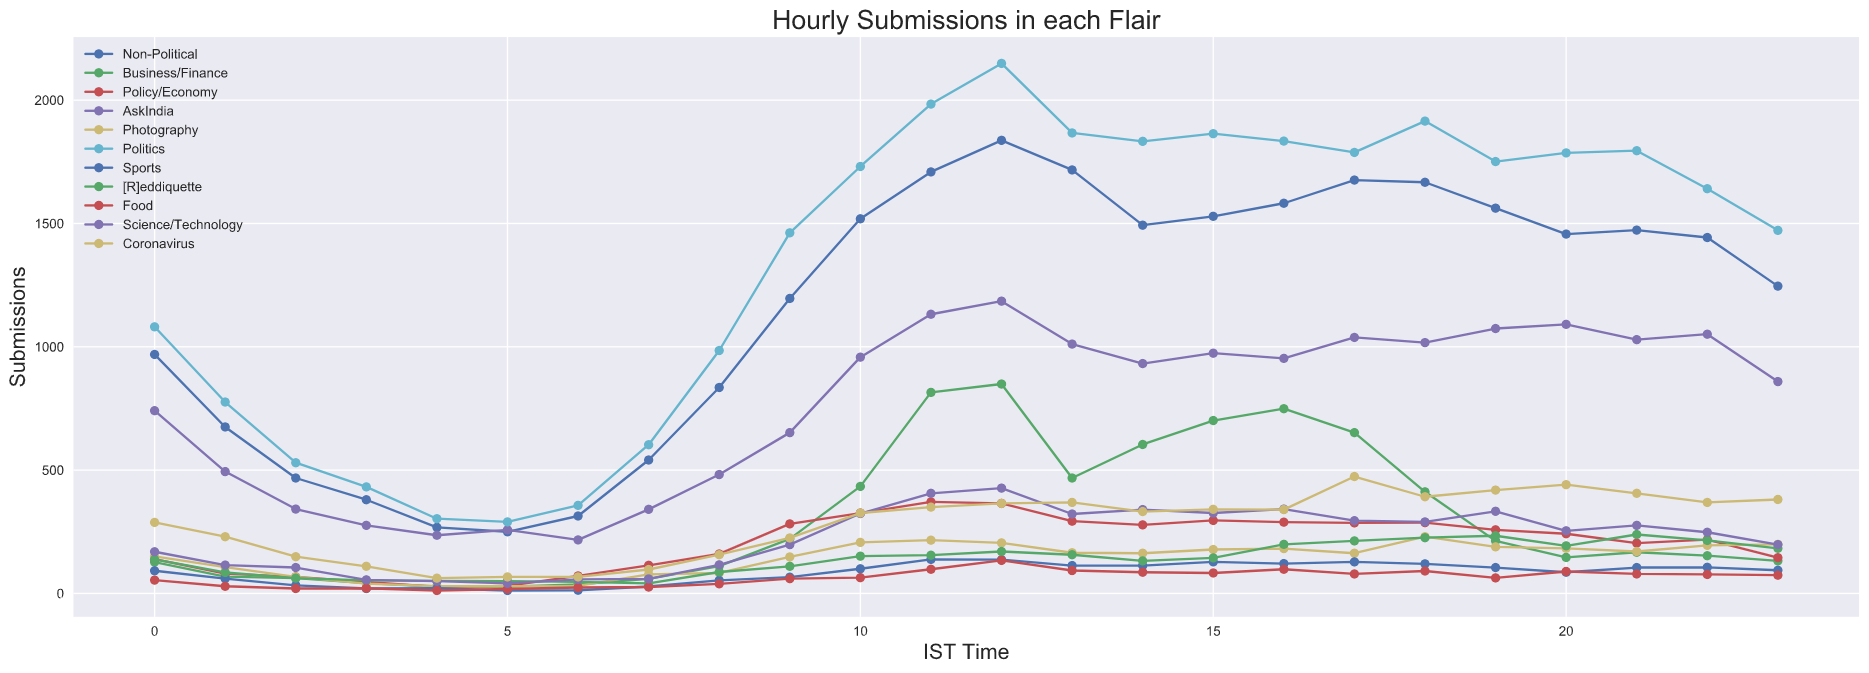

In [110]:
Image("assets/hourly_submission_flair.png")

#### **Inference**
- Most of Submission were made after 10 IST
- Submission peaked at 12 IST
- Submission troughed at 5 IST which is quite obvious.


#### Hourly Submission in each flair

In [106]:
%%time
"""
    This is very elegant code to plot the hourly submission for each flair
    The idea is to filter the submission according to flair and group it by hour and then plot the line
    Repeat the process for each flair
"""
plt.figure(figsize=(24, 8))
for flair in new_df.link_flair_text.unique():
    new_df.link_flair_text[new_df.link_flair_text==flair].groupby(new_df.hour).count().plot.line(
        label=flair, 
        marker="o"
    )
plt.title("Hourly Submissions in each Flair", fontdict={"fontsize":20})
plt.ylabel("Submissions", fontdict={"fontsize":16})
plt.xlabel("IST Time", fontdict={"fontsize":16})
plt.axis("tight")
plt.legend()
plt.show()

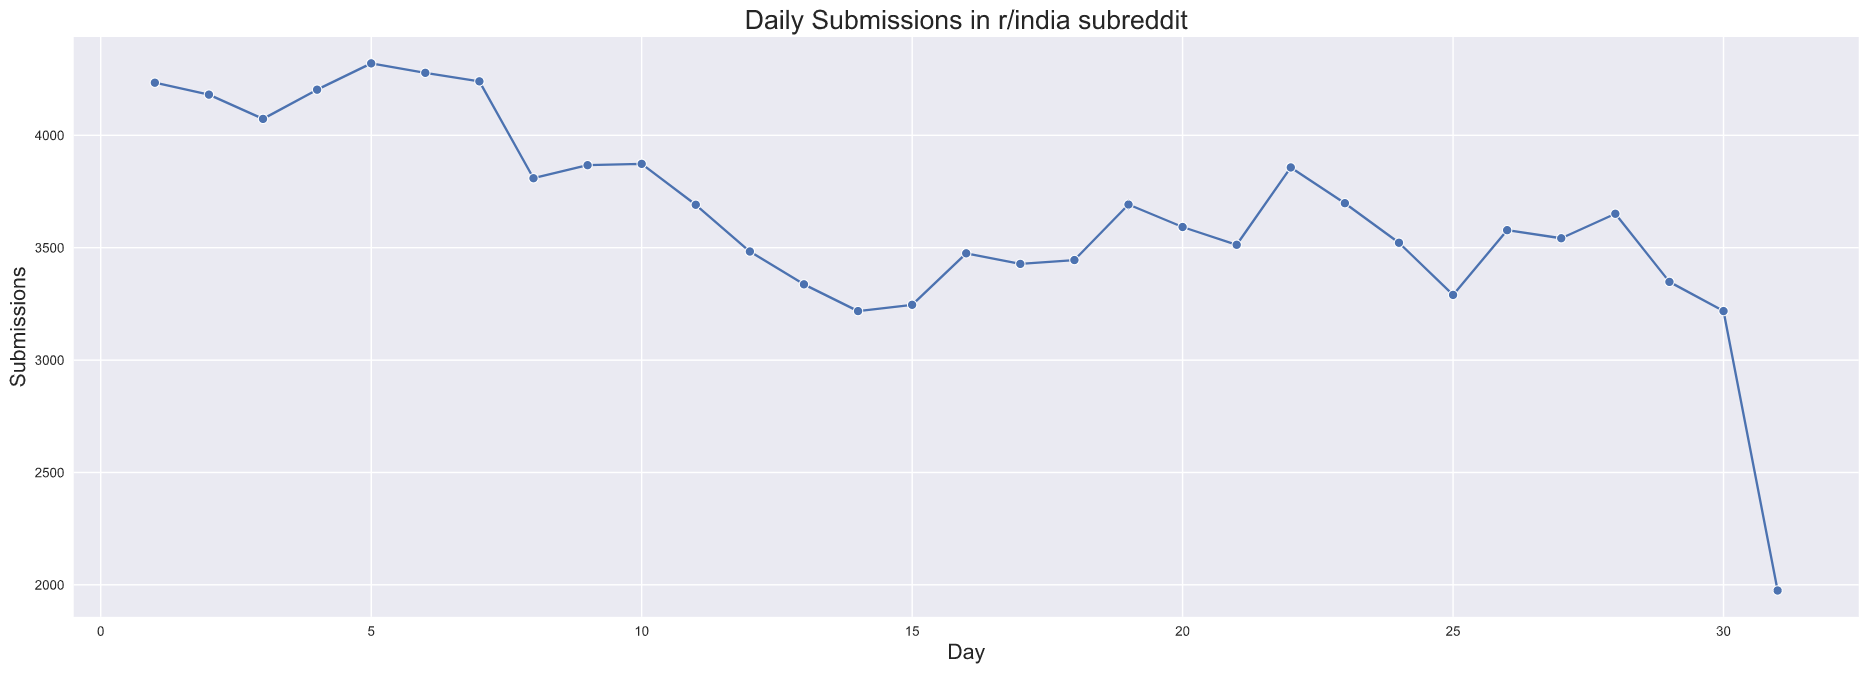

In [111]:
Image("assets/daily_submission.png")

#### **Inference**
- Submission pattern remains pretty much same as subreddit hourly submisisons
- Its hard to have any correlation between flair and time of submission

#### Daily Submmissions 

In [105]:
%%time
"""
    The idea is to filter the submission according to flair and group it by day and then plot the line
    Repeat the process for each flair
"""
plt.figure(figsize=(24, 8))
for flair in new_df.link_flair_text.unique():
    new_df.link_flair_text[new_df.link_flair_text==flair].groupby(new_df.day).count().plot.line(
        label=flair, 
        marker="o"
    )
plt.title("Daily Submissions in each Flair", fontdict={"fontsize":20})
plt.ylabel("Submissions", fontdict={"fontsize":16})
plt.xlabel("Day", fontdict={"fontsize":16})
plt.axis("tight")
plt.legend()
plt.show()

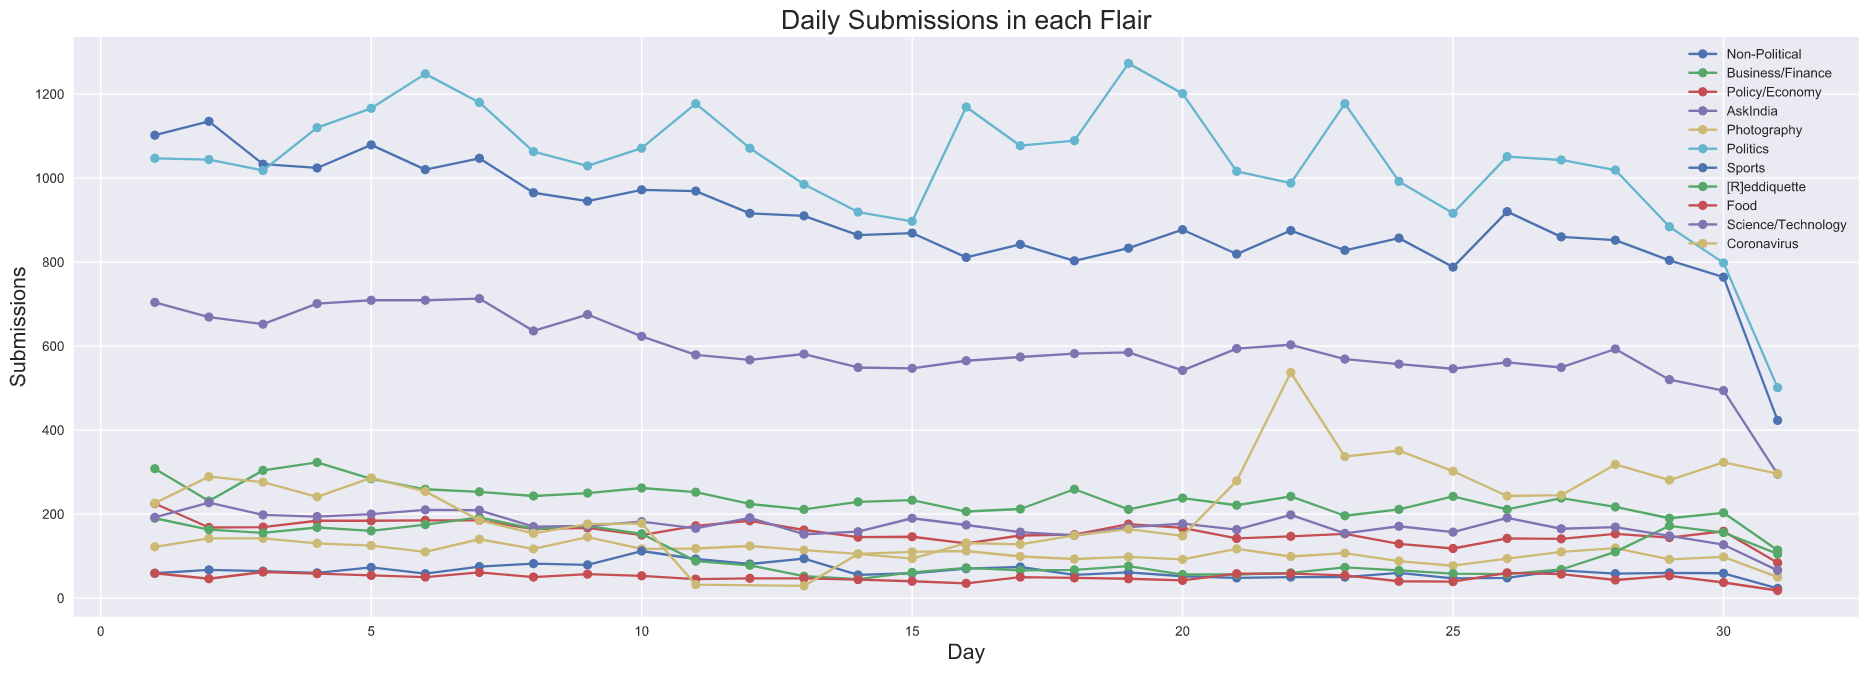

In [112]:
Image("assets/daily_submission_flair.png")

### Flair Distribution

In [28]:
# get the new flairs and  corresponding frequencies
new_flairs, new_freq = new_df.link_flair_text.value_counts().index, new_df.link_flair_text.value_counts().values
new_flairs_freq = dict(zip(new_flairs, [int(each) for each in new_freq]))

##### Write the dictionary into json file we might need it in web app data visualization

In [41]:
# with open("flairs_freq.json", 'w') as fp:
#     json.dump(new_flairs_freq, fp)

#### Flair distirbution plot

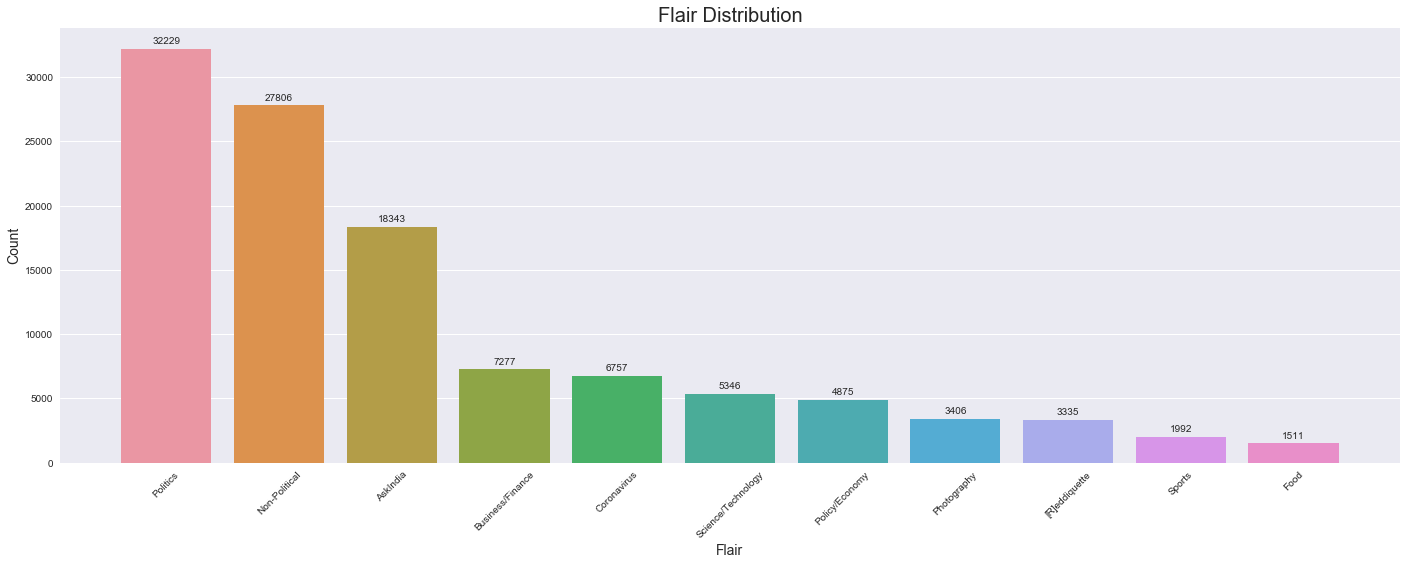

Wall time: 373 ms


In [42]:
%%time
"""
    % Submissions in a flair 

"""
plt.figure(figsize=(24, 8))
ax = sns.barplot(x=new_flairs, y=new_freq)
utility.autolabel(ax)
ax.set_xticklabels(new_flairs, rotation=45)
plt.title("Flair Distribution", fontdict={'fontsize':20})
plt.xlabel("Flair", fontdict={'fontsize':14})
plt.ylabel("Count", fontdict={'fontsize':14})
plt.axis('tight')
plt.show()

#### **Inference**
- Political and Non-Political flair constitues ~52% of total submissions
- Data is still imabalance

#### Title, Body, URL and Comments Concatenation
- Title, Body and URL are the text data associated with the flair. There is string correlation between the text and flair
- selftext(body), title, comments and url are the text data we are going to proceed further to build text classifiers, following will be new cols in dataframe
- title + body
- title + body + comments + url

- ##### We can impute the NA fields with empty string (no title have na values)


In [29]:
"""
    Before conactenating the two string (both may or may not be None) it is imporant to impute them with empty string otherwise it will throw error
    
"""
new_df.selftext = new_df.selftext.fillna("")
new_df.comments = new_df.comments.fillna("")
new_df.url = new_df.url.fillna("")

In [46]:
## Plot the NA bar first

Wall time: 0 ns


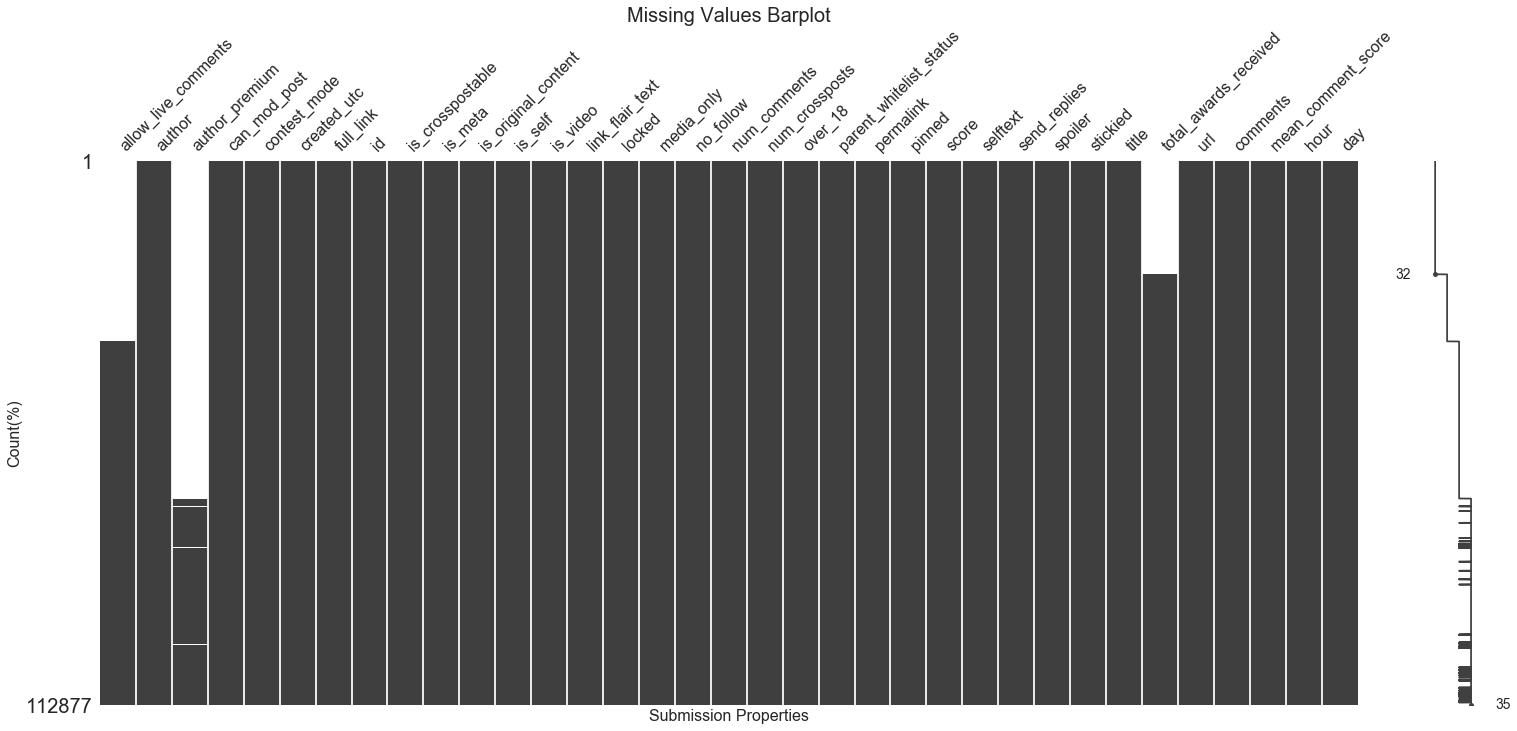

In [47]:
%time
"""
    Checking if there is still any crucial missing (or None) data. If so  I will impute them if possible or 
    will remove those entries. 
"""
msno.matrix(new_df)
plt.title("Missing Values Barplot", fontdict={"fontsize":20})
plt.xlabel("Submission Properties", fontdict={"fontsize":16})
plt.ylabel("Count(%)", fontdict={"fontsize":16})
plt.show()

#### **Inference**
- Now we can see that we don't have any missing values in selftext, comments and url its time to combine them to and create new cols 

In [30]:
# concatenating the text cols to create text corpus coloumn
new_df["title_selftext"] = new_df.title + " " + new_df.selftext

#text will be new col in datafram which will have all textual data related to a post 
new_df['text'] = new_df.title + " " + new_df.selftext + " " + new_df.comments
new_df['url_split'] = new_df['url'].progress_apply(lambda x:clean_text(x))
new_df['text'] = new_df.text + ' ' + new_df.url_split

100%|██████████| 112877/112877 [00:31<00:00, 3542.16it/s]


### Word Cloud (before cleaning)
- url was cleaned to extract the textual information

In [57]:
# Pandas Series for each flair
flairs = new_flairs_freq.keys()
flairs_series = []
for flair in flairs:
    flairs_series.append(new_df[new_df.link_flair_text==flair].text)

In [104]:
%%time
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 4
for i, pds in zip(range(1, columns*rows +1), flairs_series):
    text = pds.values
    # mask = np.array(Image.open("India.jpg"))
    wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = STOPWORDS).generate(str(text))
    fig.add_subplot(rows, columns, i)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(list(flairs)[i-1], fontdict ={'fontsize':20})
    plt.tight_layout(pad=2)
    plt.axis('off')
# # Save the img 
# plt.savefig("worldcloud.png")
plt.show()

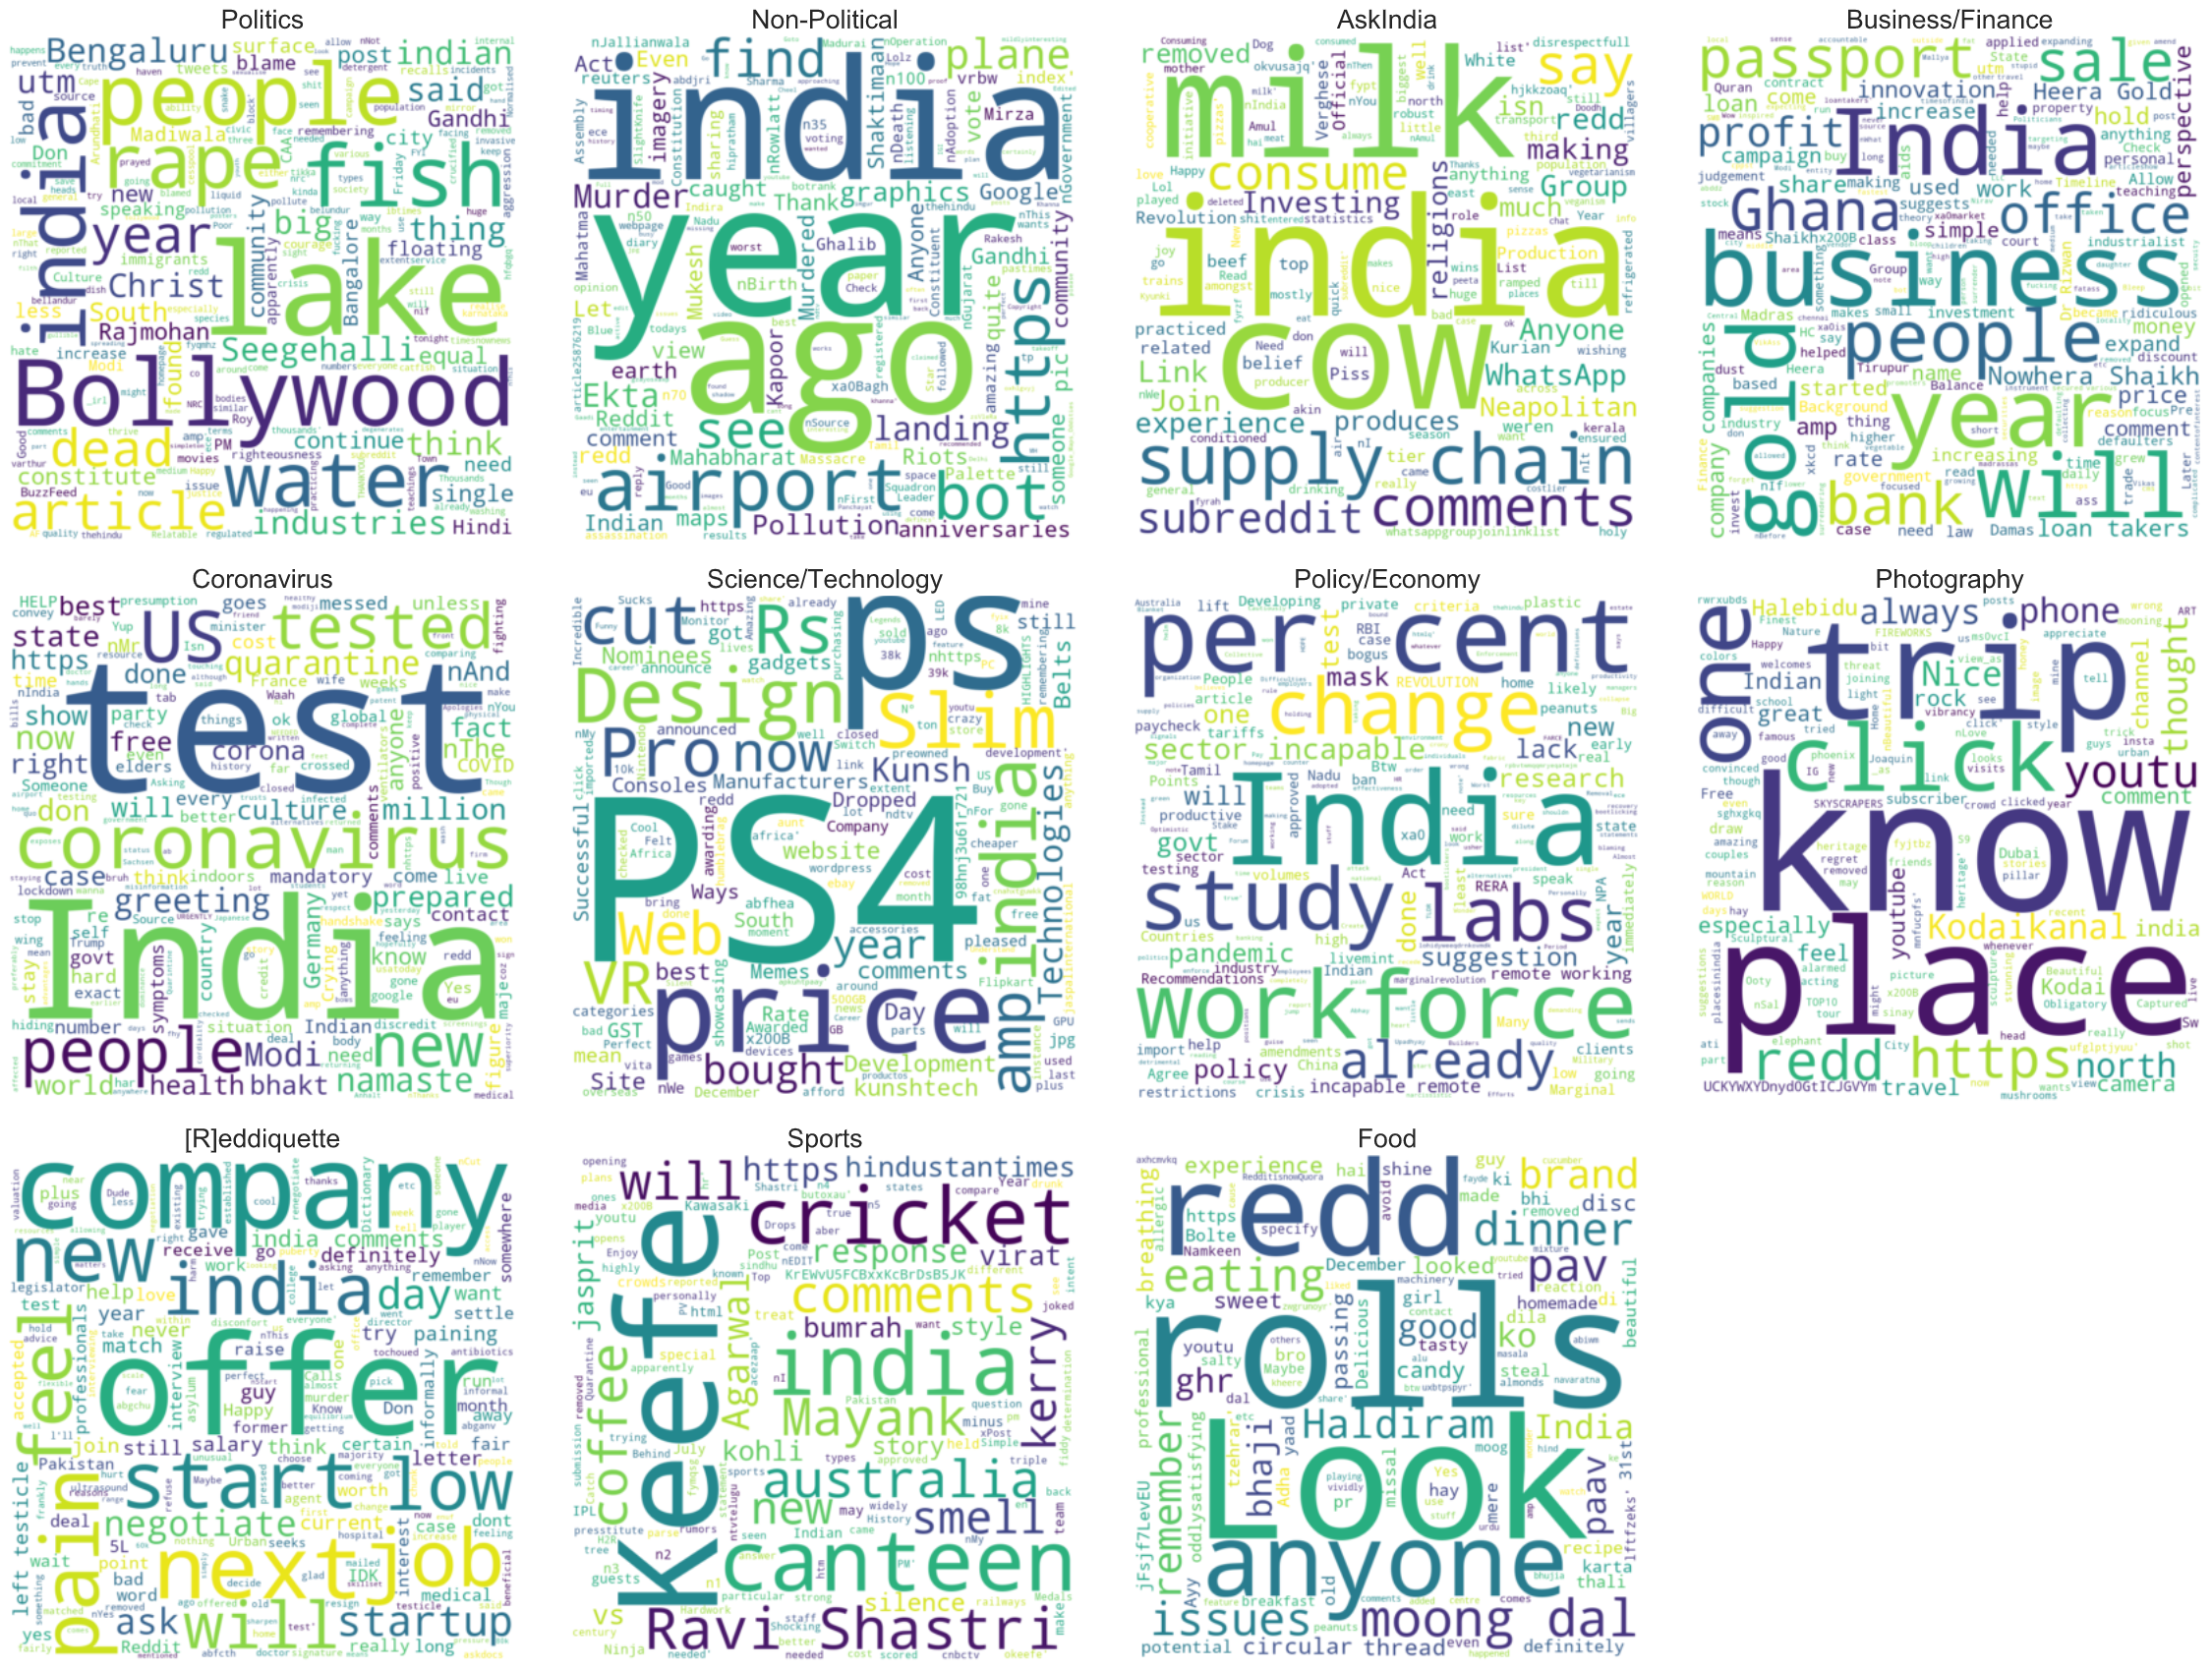

In [113]:
Image("assets/word_cloud.png")

#### Inference
- In the word cloud we can see that Wod Cloud information is pretty much related to the flair 

## Statistical, Numerical and NLP Feature Analysis

In [31]:
# num of submissions in each flairs
print(new_df.link_flair_text.groupby(new_df.link_flair_text).count())

link_flair_text
AskIndia              18343
Business/Finance       7277
Coronavirus            6757
Food                   1511
Non-Political         27806
Photography            3406
Policy/Economy         4875
Politics              32229
Science/Technology     5346
Sports                 1992
[R]eddiquette          3335
Name: link_flair_text, dtype: int64


### Comment and Socre distirbution

#### Avg num_comments distribution

In [32]:
"""
    Calculate the total number of comments in each flair
    Calculate the Avg Comments/Submission for each flair
"""
num_comments = []
for flair in new_df.link_flair_text.unique():
    num_comments.append(new_df.num_comments[new_df.link_flair_text==flair].sum())
flair_comments = dict(zip(new_df.link_flair_text.unique(), num_comments))
for key in flair_comments.keys():
    flair_comments[key] /= new_flairs_freq[key]

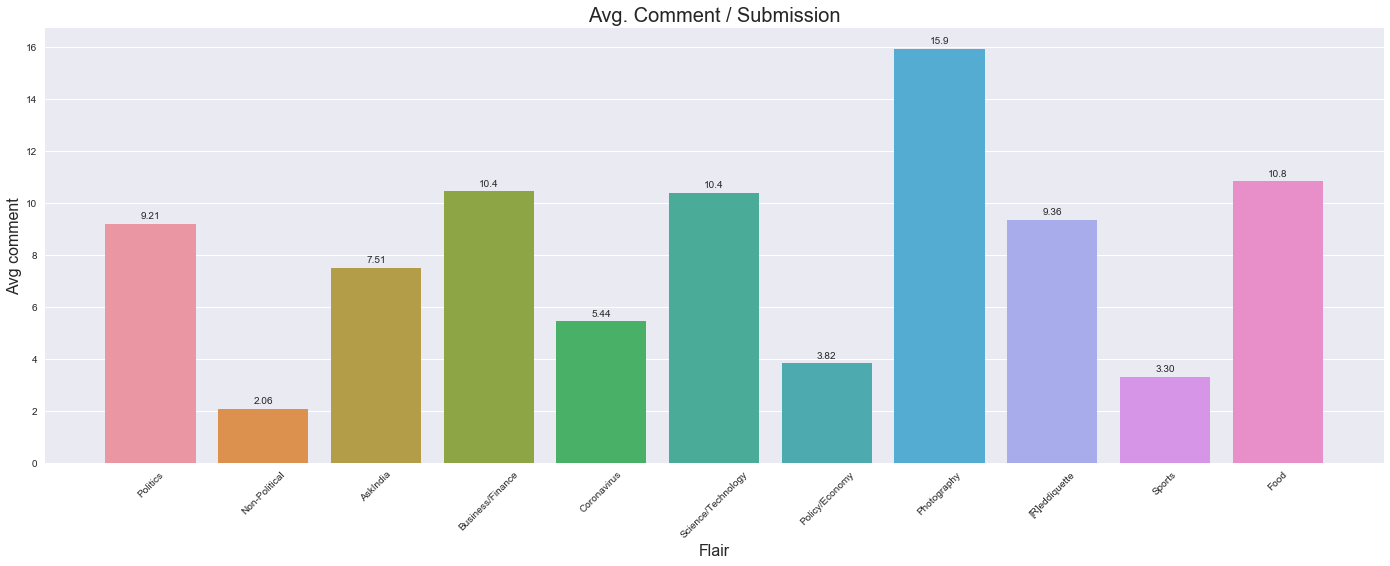

Wall time: 450 ms


In [61]:
%%time
"""
    Barplot of the avg comment / submission 
"""
plt.figure(figsize=(24, 8))
ax = sns.barplot(x = new_df.link_flair_text.unique(), y=list(flair_comments.values()))
autolabel(ax, dtype=float)
ax.set_xticklabels(new_flairs, rotation=45)
plt.title("Avg. Comment / Submission", fontdict={'fontsize':20})
plt.xlabel("Flair", fontdict={'fontsize':16})
plt.ylabel("Avg comment", fontdict={'fontsize':16})
plt.axis('tight')
plt.show()
plt.show()

#### Score distribution
- Score = Upvote - Downvote

In [33]:
"""
    Calculate the total score in each flair
    Calculate the Avg Score/Submission for each flair
"""
total_score = []
for flair in new_df.link_flair_text.unique():
    total_score.append(new_df.score[new_df.link_flair_text==flair].sum())
flair_score = dict(zip(new_df.link_flair_text.unique(), total_score))
for key in flair_score.keys():
    flair_score[key] /= new_flairs_freq[key]

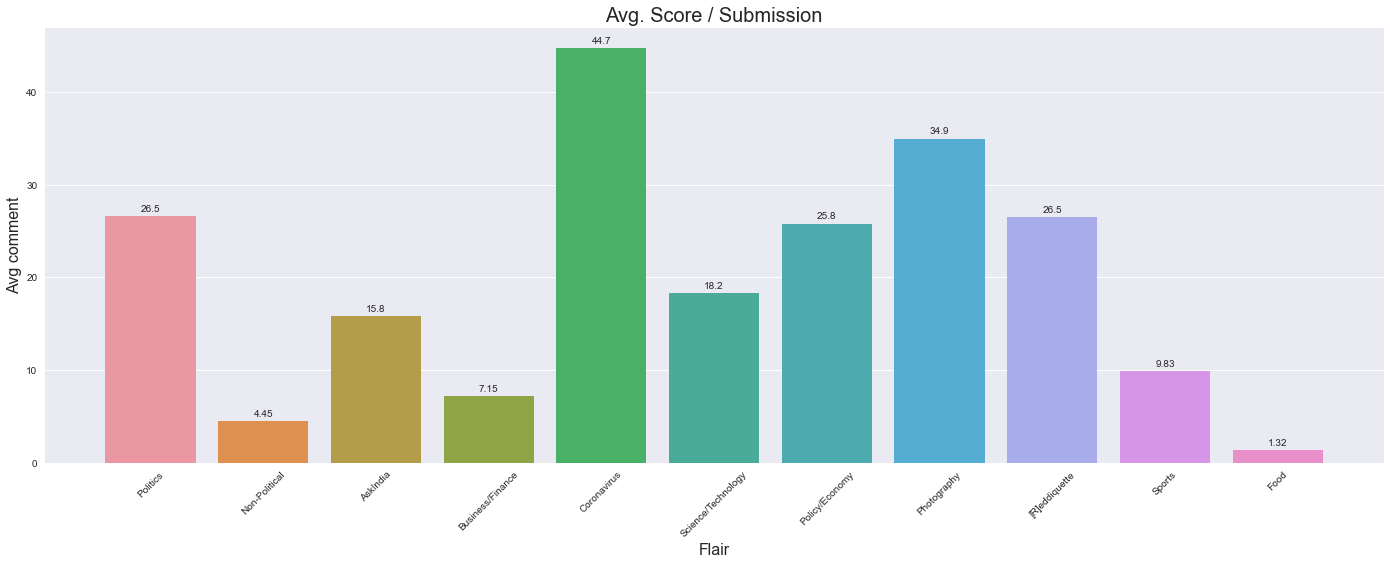

Wall time: 474 ms


In [36]:
%%time
"""
    Barplot of the avg score / submission over flair
"""
plt.figure(figsize=(24, 8))
ax = sns.barplot(x = new_df.link_flair_text.unique(), y=list(flair_score.values()))
autolabel(ax, dtype=float)
ax.set_xticklabels(new_flairs, rotation=45)
plt.title("Avg. Score / Submission", fontdict={'fontsize':20})
plt.xlabel("Flair", fontdict={'fontsize':16})
plt.ylabel("Avg comment", fontdict={'fontsize':16})
plt.axis('tight')
plt.show()
plt.show()

#### **Inference**
- The above plots show these statstical features may have a correlation with flair
- ie: Coronavirus has highest avg score while photography has highest avg comment

### NLP Features

In [37]:
## Although we have calculate these features into nlp features but since data is in different datafram
## it will save  some to cal again and plot (before merging both dfs)
new_df['word_count'] = new_df['text'].apply(lambda comment: len(comment.split()))
new_df['char_count'] = new_df['text'].apply(len) 
new_df['word_density'] = new_df['char_count']/new_df['word_count']

-  '#%02x%02x%02x' % get_random_color() to convert rgb into hex values

#### word_count distribution

In [82]:
%%time
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 4
for i, flair in zip(range(1, columns*rows +1), flairs):
    fig.add_subplot(rows, columns, i)
    ax = sns.distplot(
        new_df.word_count[new_df.link_flair_text==flair], 
        hist_kws={"linewidth": 2, "color":'#%02x%02x%02x' % get_random_rgb()}, 
        kde_kws={"linewidth":2, "color":'black'}, 
    )
    ax.set_title(list(flairs)[i-1], fontdict ={'fontsize':20})
    ax.set_xlabel("Word Count", fontdict ={'fontsize':16})
plt.tight_layout(pad=1)
plt.show()

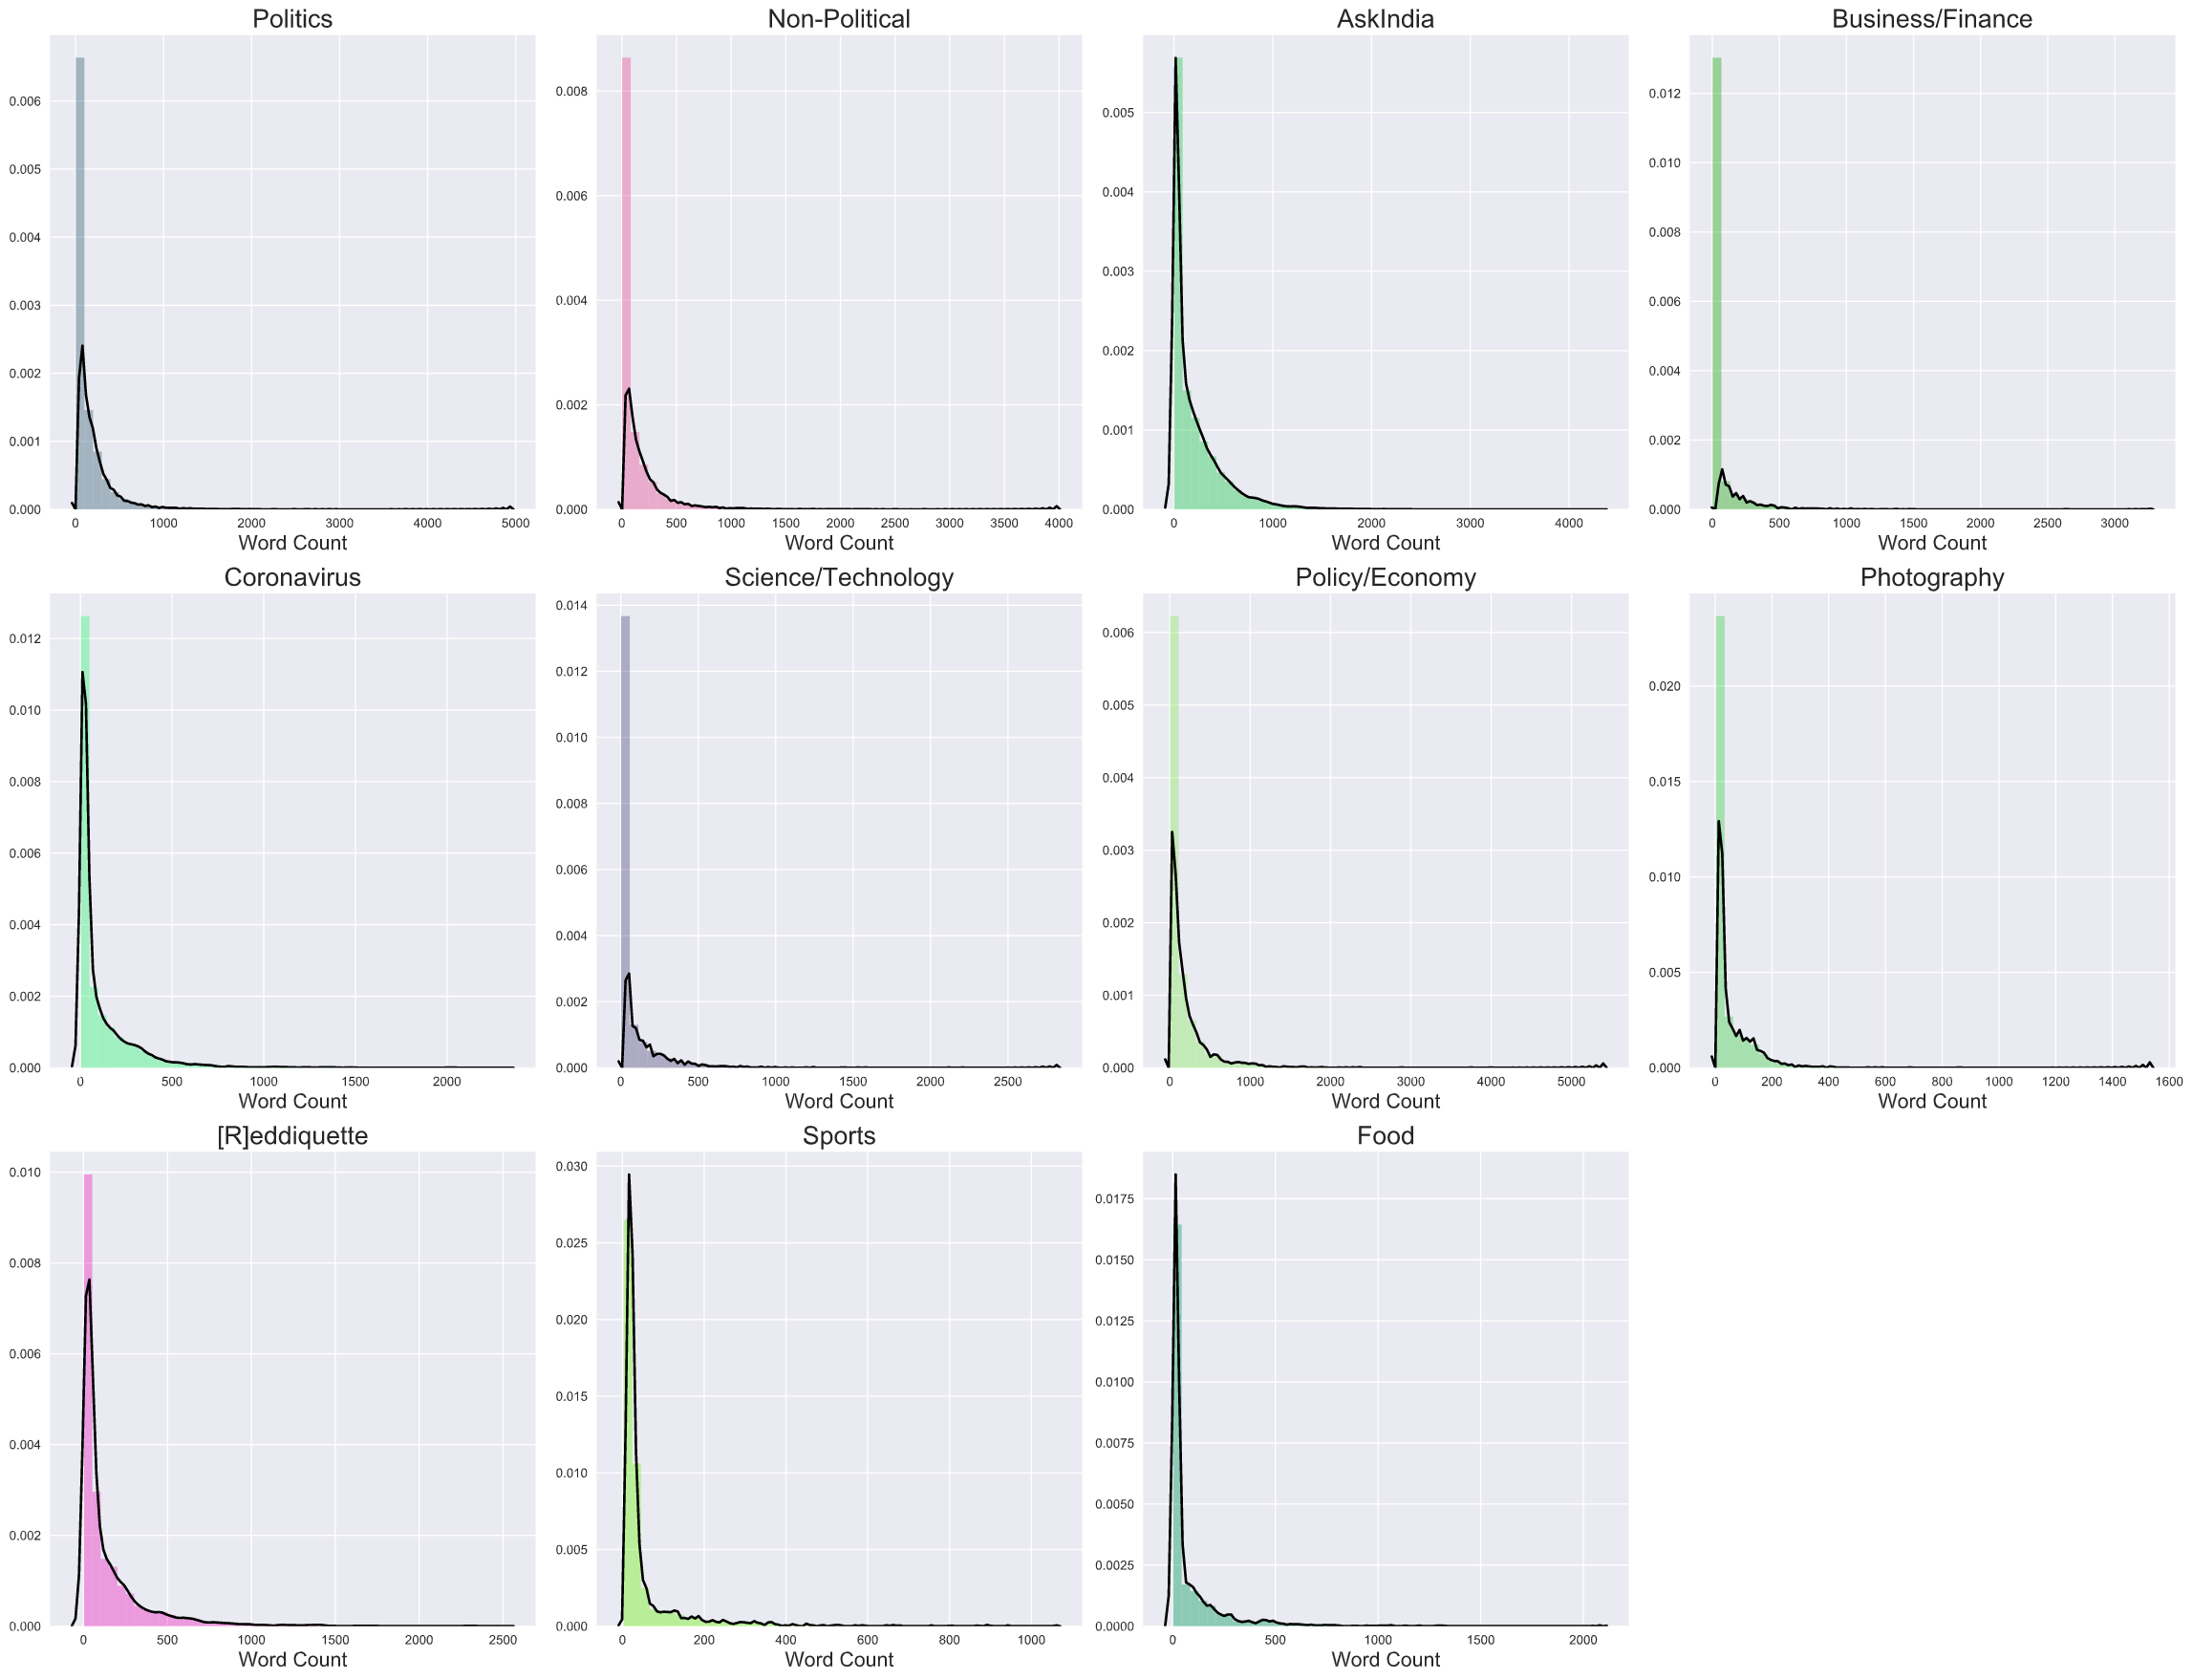

In [90]:
Image("assets/word_count.png")

In [74]:
print(new_df.char_count.describe())

count    112877.000000
mean        744.998769
std        1263.653503
min          13.000000
25%         111.000000
50%         216.000000
75%         881.000000
max       32352.000000
Name: char_count, dtype: float64


#### word_density distribution

In [83]:
# word density distribution of each flair
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 4
for i, flair in zip(range(1, columns*rows +1), flairs):
    fig.add_subplot(rows, columns, i)
    ax = sns.distplot(
        new_df.word_density[new_df.link_flair_text==flair], 
        hist_kws={"linewidth": 2, "color":'#%02x%02x%02x' % get_random_rgb()}, 
        kde_kws={"linewidth":2, "color":'black', "bw":1.5},
    )
    ax.set_title(list(flairs)[i-1], fontdict ={'fontsize':20})
    ax.set_xlabel("Word Density", fontdict ={'fontsize':16})
plt.tight_layout(pad=1)
plt.show()

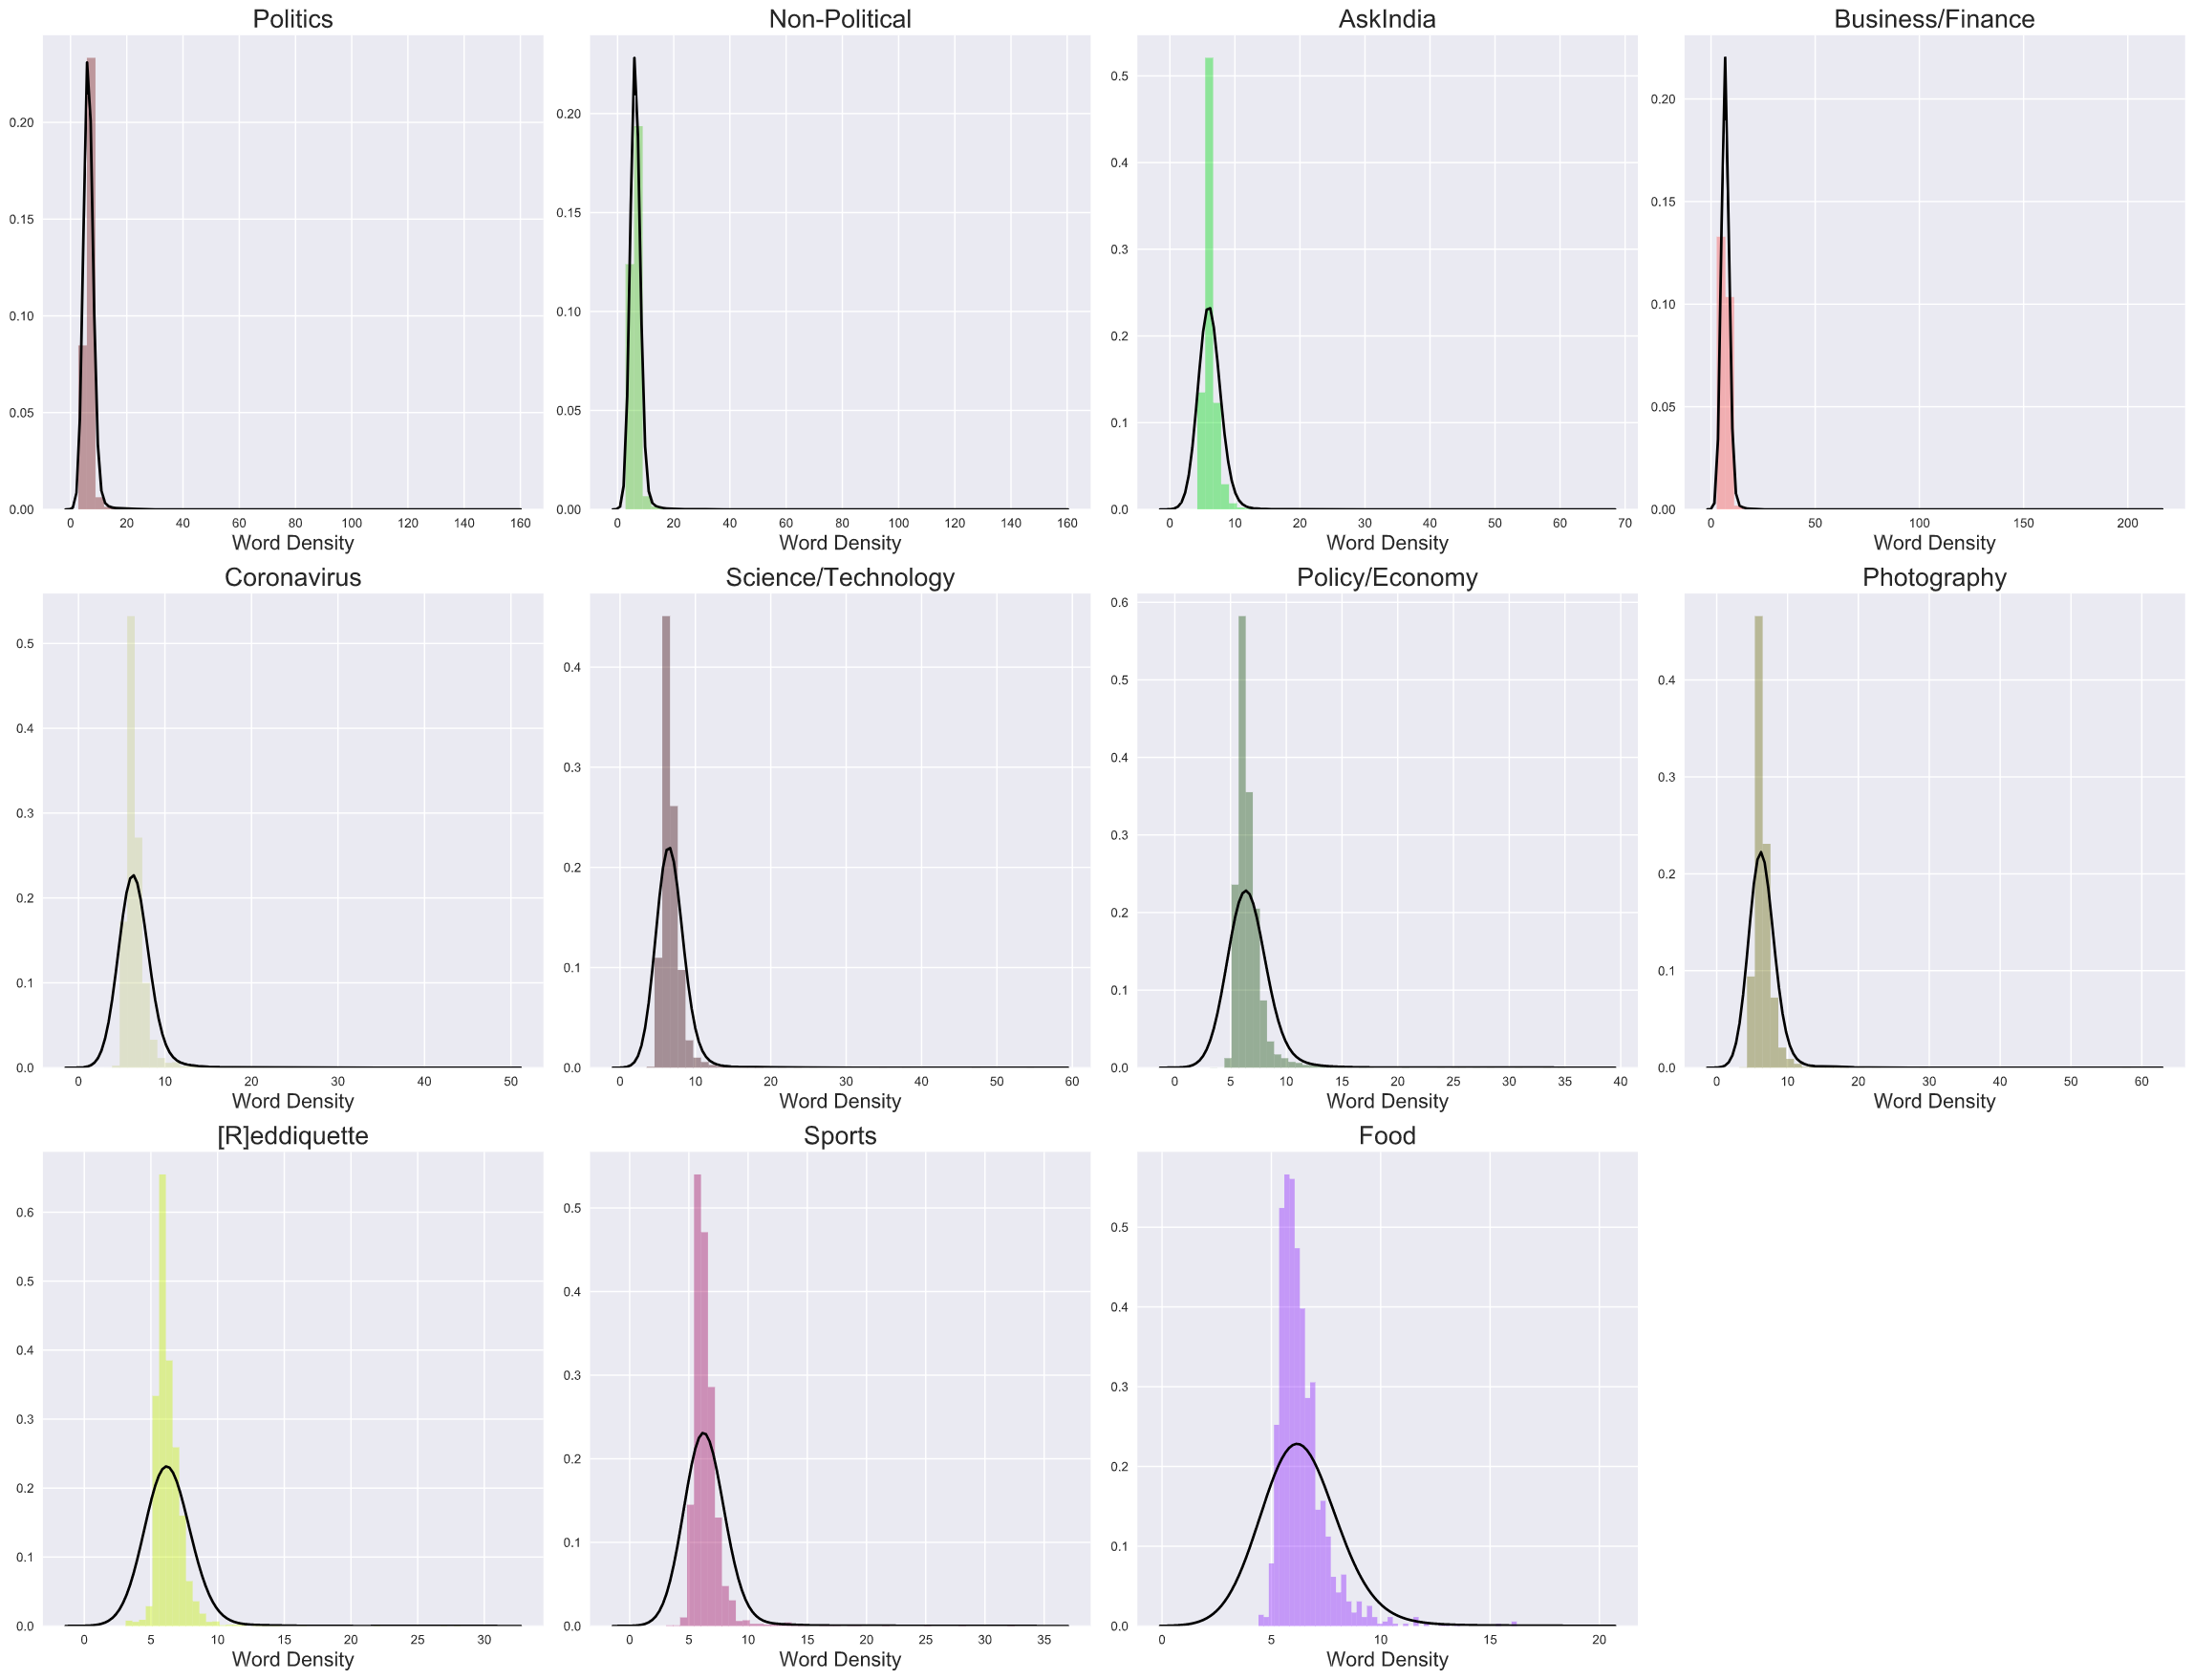

In [89]:
Image("assets/word_density.png")

from IPython.display import Image
Image("assets/India.png")

#### num_comments distribution

In [93]:
# num_comments distribution with rug 
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 4
for i, flair in zip(range(1, columns*rows +1), flairs):
    fig.add_subplot(rows, columns, i)
    ax = sns.distplot(
        new_df.num_comments[new_df.link_flair_text==flair],
        rug=True,
        hist_kws={"linewidth": 2, "color":'#%02x%02x%02x' % get_random_rgb()}, 
        kde_kws={"linewidth":2, "color":'black', "bw":1.5},
    )
    ax.set_title(list(flairs)[i-1], fontdict ={'fontsize':20})
    ax.set_xlabel("num_comments", fontdict ={'fontsize':14})
plt.tight_layout(pad=1)
plt.show()

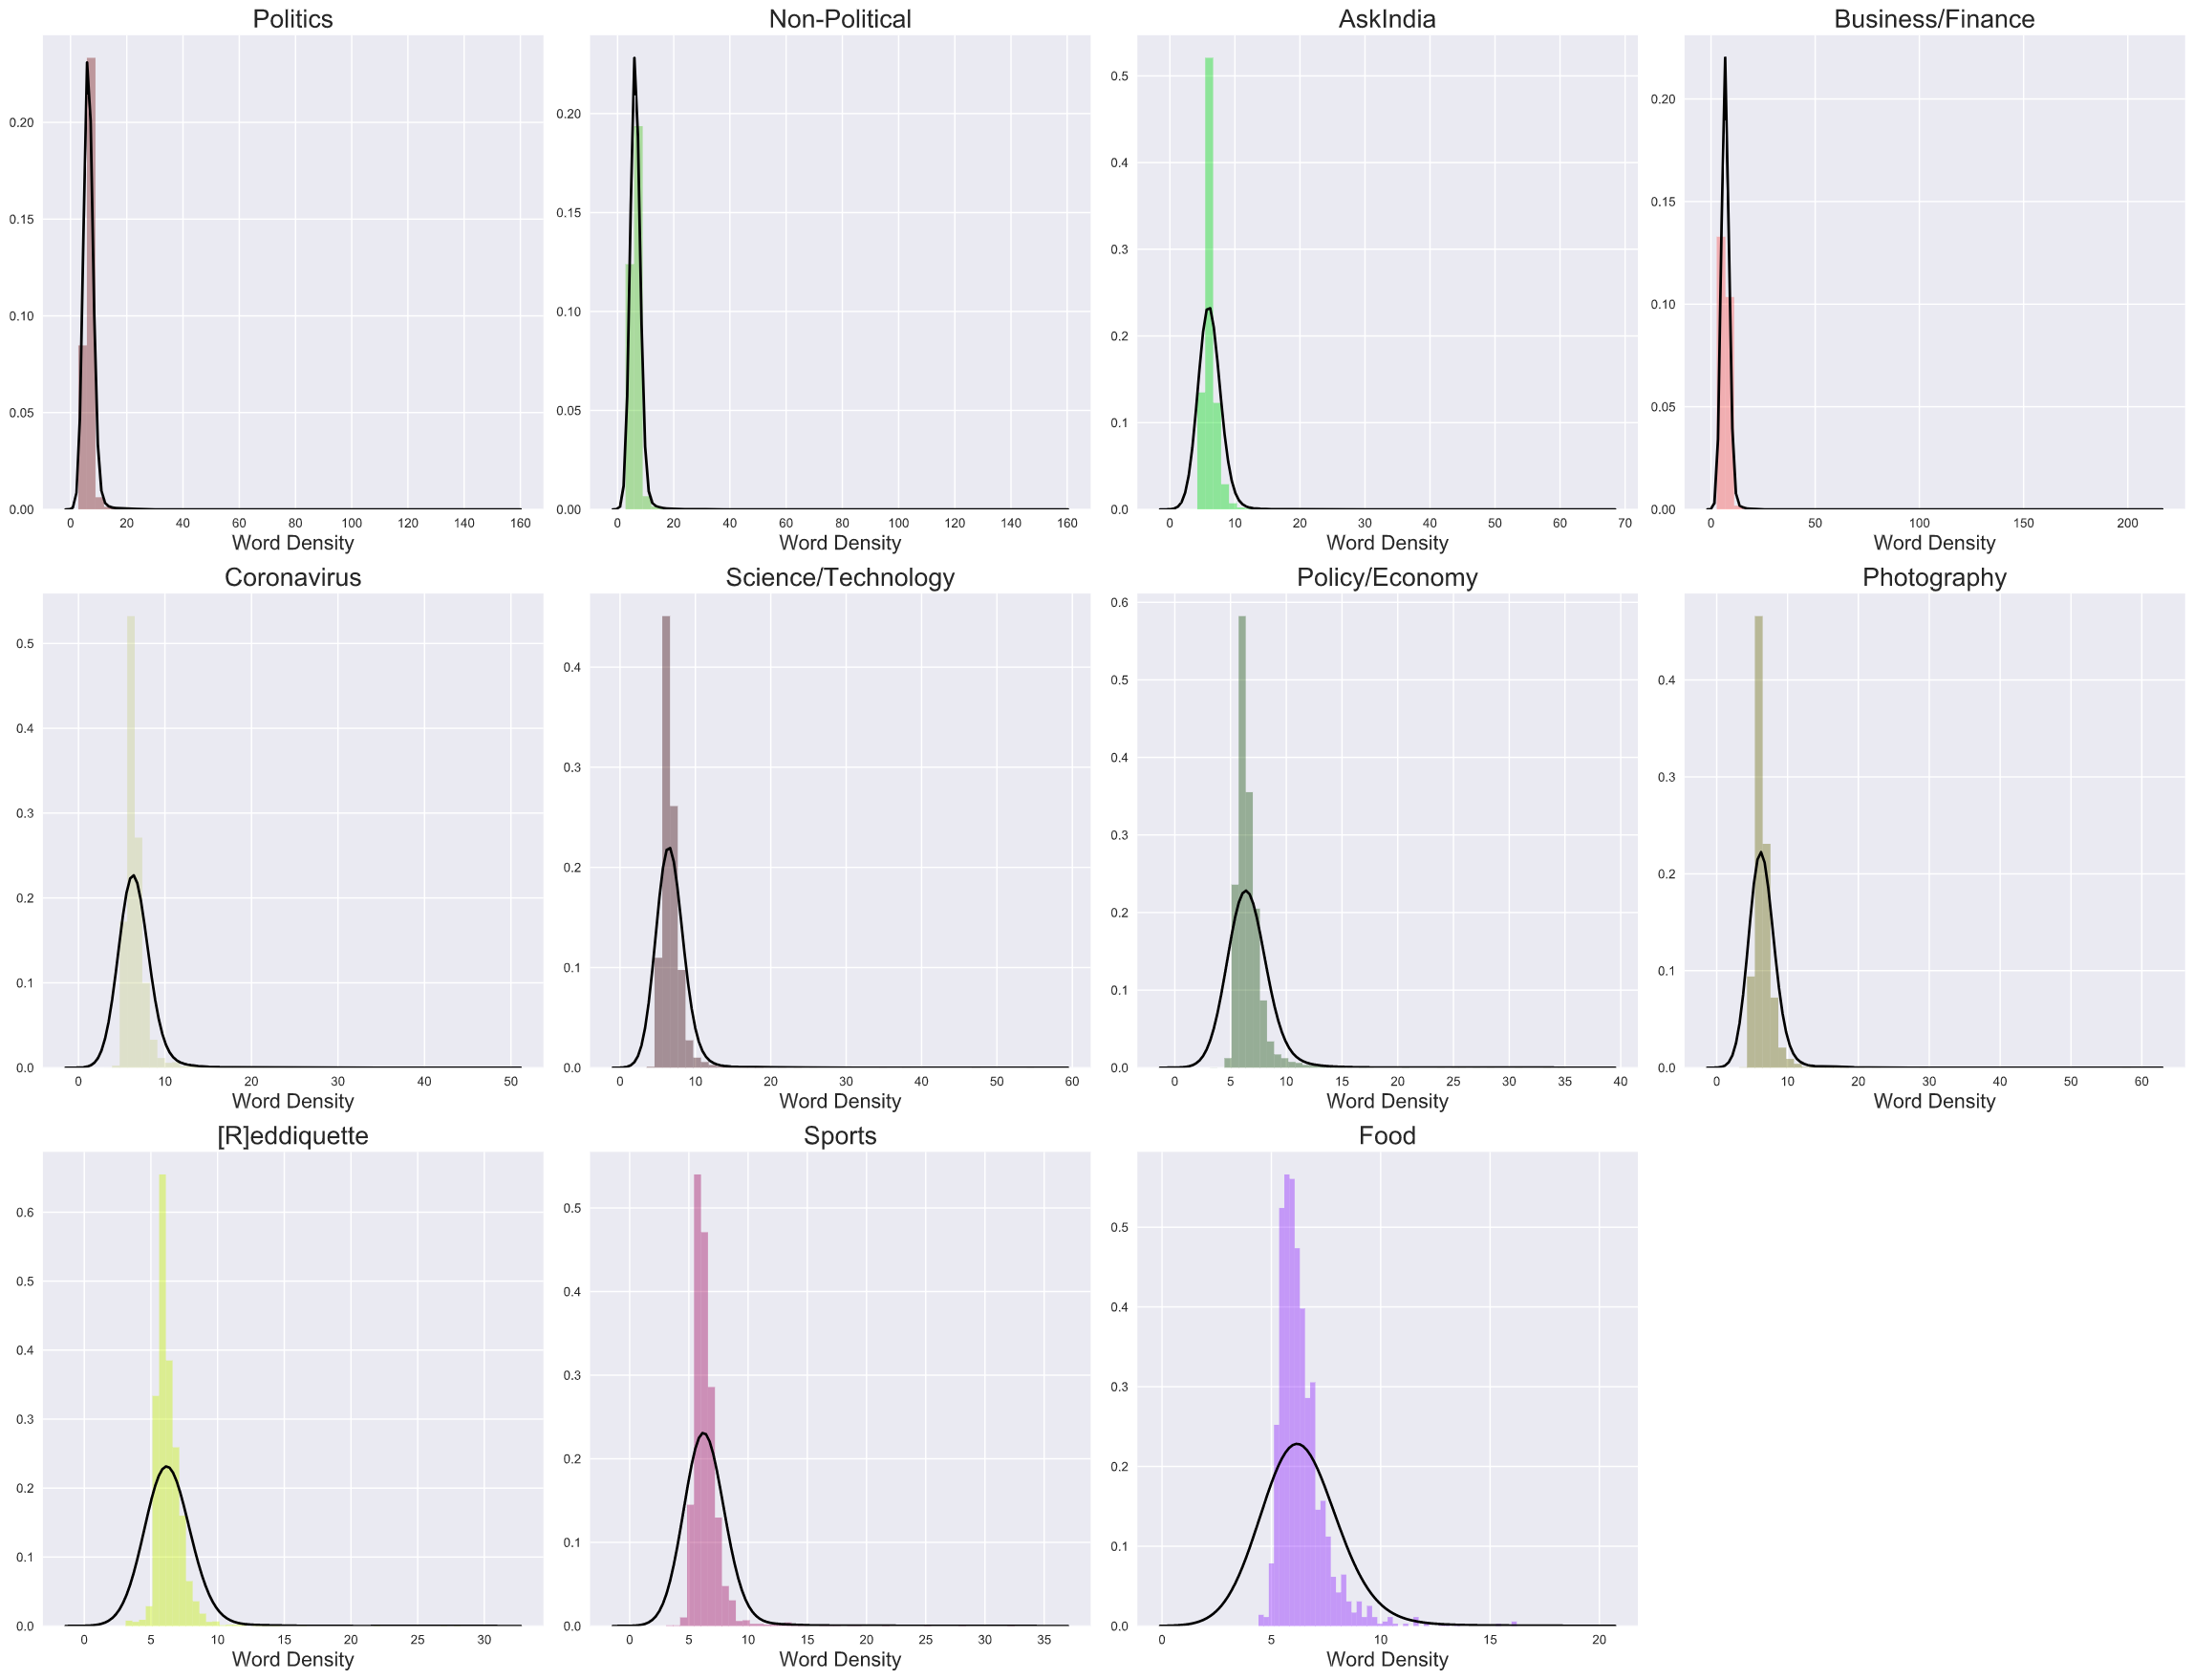

In [94]:
Image("assets/num_comments.png")

#### Note:
- bw=1.5 for score and num_coments, because for some flairs kernel density estimation bw is 0.
- The bandwidth is a measure of how closely we want the density to match the distribution.

#### Inference:
- Measures of spread of the distribution differs from flair to flair which is sign of correlation between target variable(flair) and indepdent variable word_count and word density(derived from word_count and char_count)


#### Visulizing each nlp/numerical/statistical features for each flair will make our notebook extremely large may be unreachable so ploting a correlation matrix instead

### Correlation matrix of NLP features

In [38]:
%%time

nlp_feat = new_df[['text']].copy()
"""
Order is important: Some numerical_features are used to calculate the pos_features
"""
nlp_feat = numerical_features(nlp_feat)
nlp_feat = pos_features(nlp_feat)

100%|██████████| 112877/112877 [00:01<00:00, 64334.30it/s]Wall time: 21min 21s



In [78]:
#more nlp features
"""
    Plotting correlation(between diff nlp features) matrix
"""
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(nlp_feat.drop(['text'], axis=1).corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Correlation Matrix for NLP Features", fontsize=18)

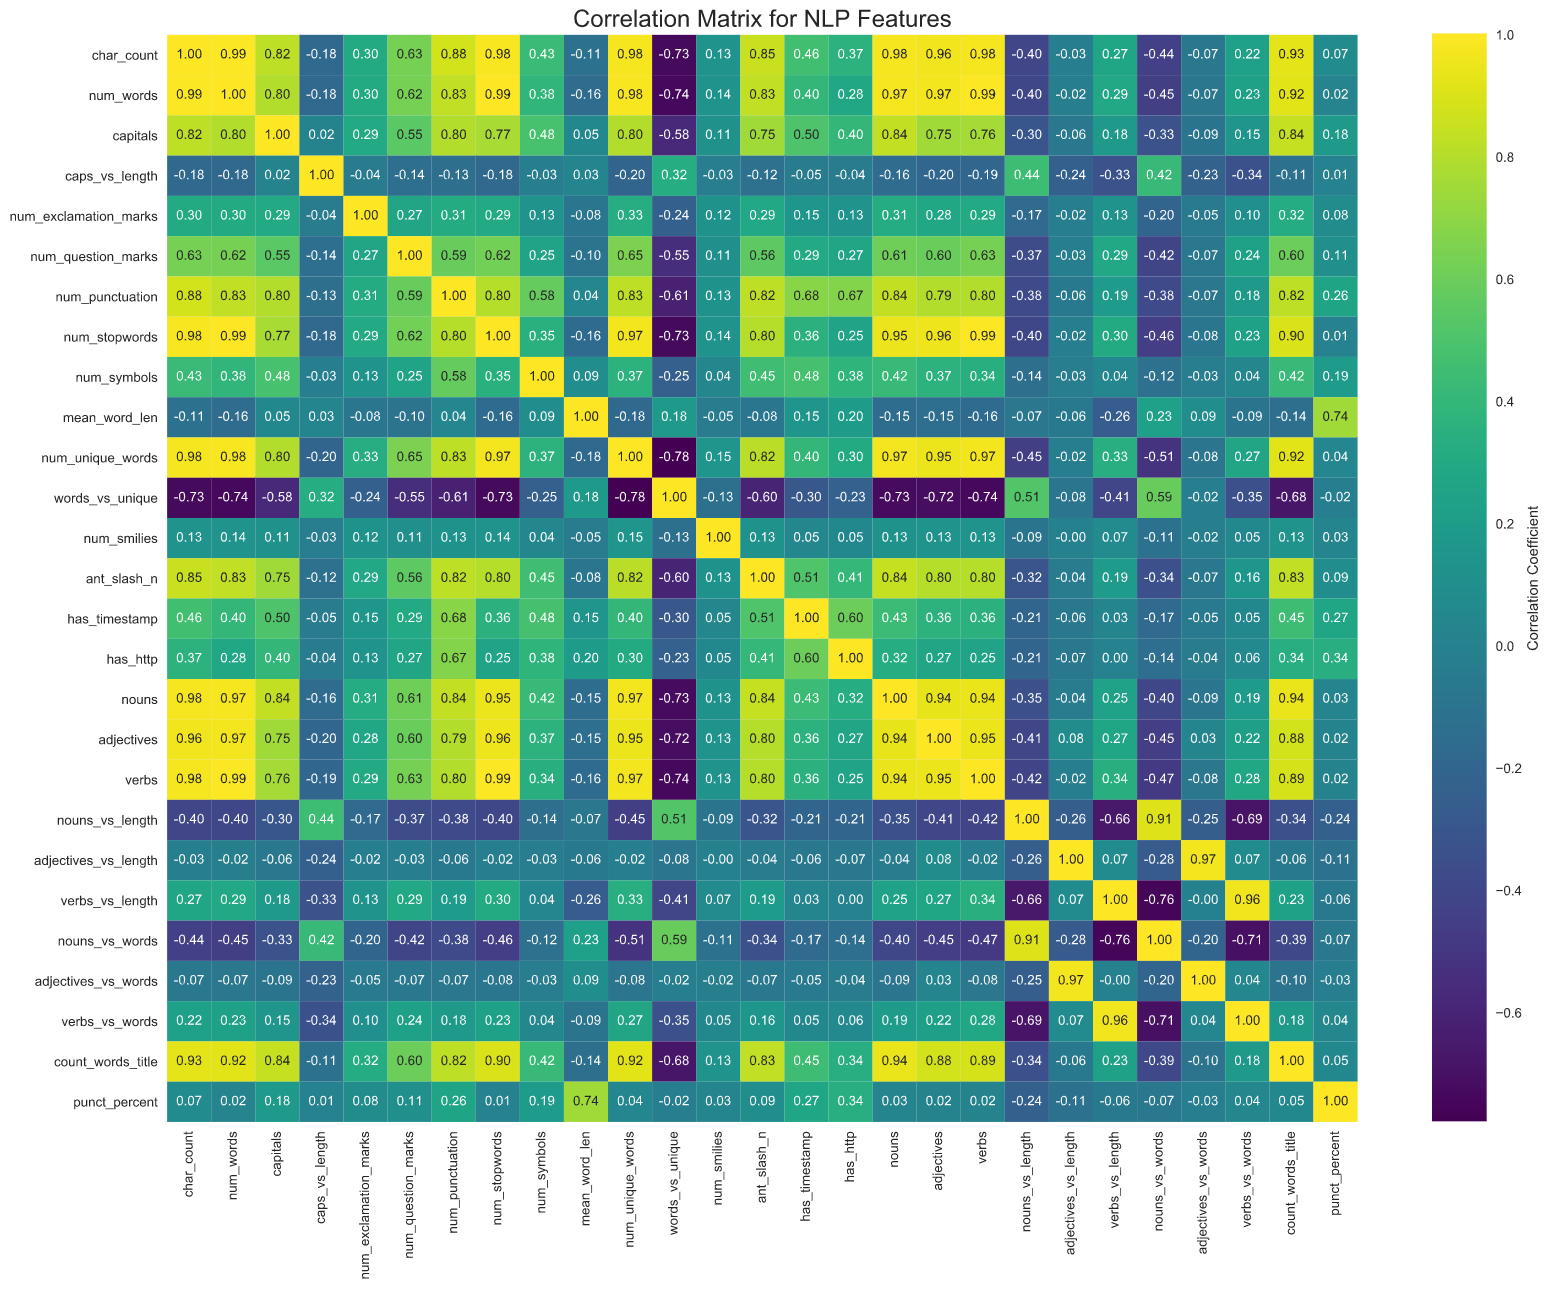

In [95]:
Image("assets/correlation_matrix.png")

## Text Preprocessing
- There might be some empty text after cleaning in this case text has only special/numeric chars or stopwords we would like to remove those entries
- Text Preprocessing mainly involves following operations(in no particular order):
  - Lower case conversion
  - Special Chars, Punctuatiions and Number removal
  - Emoji/Emoiticon to text conversion
  - Handling urls
  - HTML Tags removal
  - Large White Space Removal
  - Stopwords removal
  - Spelling Correction
  - Tokenization

We have two dataframes new_df and nlp_feat both dataframes carry two different types of features
nlp_feat carries numerical and pos feature of the text data while new_df carries textual and statstical features. We have to merge them into single dataframe before preprocessing

In [43]:
# new_df df has text col so drop it from anyone of them
nlp_feat.drop(['text'], axis=1, inplace=True)

In [44]:
# merge the both dataframes
df = pd.concat([new_df, nlp_feat], axis=1)

# drop the features which still have na values
df.dropna(axis=1, inplace=True)

In [45]:
# remote the duplicate from main df
print(f'before duplicate removal = {df.shape[0]}')
df = df.drop_duplicates(subset=['text'], keep='first')
print(f'after duplicate removal = {df.shape[0]}')

before duplicate removal = 112877
after duplicate removal = 112284


In [ ]:
# # # save the data before preprocessing
# # df.to_csv("df.csv", index=False)
# ## read csv (if session has expired)
# df = pd.read_csv("df.csv")

In [46]:
# # %%time
df['clean_text'] = df['text'].progress_apply(lambda x: clean_text(x))
# df['lemmatized'] = df['clean_text'].apply(lambda x: lemmatize(x))

100%|██████████| 112284/112284 [00:54<00:00, 2068.40it/s]


- After processing some text fields might be empty (remove them)
- There might be some submissions which will have few words, setting a threshold to select for training data
- Point 2 will act as undersampling
- I should've done it earlier It would have reduced the processing time

In [48]:
# count the unigrams after processing the text
df['unigram_count'] = df.clean_text.progress_apply(lambda x: len(x.split()))

100%|██████████| 112284/112284 [00:00<00:00, 184217.97it/s]


In [51]:
df_preprocessed = df

In [52]:
print(f'shape before cleaning {df_preprocessed.shape}')

# Dropping the rows based on NA text 
df_preprocessed = df_preprocessed.dropna(subset=['text'], axis=0)
print(f'shape after removing na {df_preprocessed.shape}')

# # Filter out those rows which have more than 10 words
df_preprocessed = df_preprocessed[df_preprocessed.unigram_count > 5]
print(f'shape after removing unigram thresh {df_preprocessed.shape}')

# Remove rows which have duplicate text data (there might be some fields which will have same text after preprocessing)
df_preprocessed = df_preprocessed.drop_duplicates(subset='text', keep='first')
print(f'shape after removing duplicate {df_preprocessed.shape}')

shape before cleaning (112284, 67)
shape after removing na (112284, 67)
shape after removing unigram thresh (106954, 67)
shape after removing duplicate (106954, 67)


## N-gram Analysis

In [54]:
def get_n_ngrams(corpus, n, size=1):
    """
        Function to get the ngrams
        corpus: text corpus
        n: num of ngrams 
        size: ngram size
        returns: ngram_words with freq
    """
    vec = CountVectorizer(ngram_range=(size, size), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [55]:
def plot_n_gram(df, n_gram, count_ngram, rotation=45):
    """
        function to plot the ngram barplot
        df: dataframe of ngrams with freq ie:  df['unigram', 'count_ngram']
        n_gram: name of the ngram ie: 'unigram', 'bigram', 'trigram' etc
        count_gram: count_gram col of the dataframe that holds the freq of ngrams # it could be    simple 
        like ngram and count then we wouldn't need these params but lets take a chill pill.
        
        returns: plots a barplot 
    """
    plt.figure(figsize=(24, 8))
    ax = df.groupby(n_gram).sum()[count_ngram].sort_values(ascending=False).plot(
        kind='bar', 
    )
#     for p in ax.patches:
#         count = int(p.get_height())
#         x = p.get_x() + p.get_width()/30
#         y = p.get_y() + p.get_height() + 0.02
#         ax.annotate(count, (x, y))
    autolabel(ax, dtype=int)
    ax.set_xticklabels(df[n_gram], rotation=rotation)
    plt.title(f"Top 20 {n_gram}s in text after removing stopwords", fontdict={'fontsize':20})
    plt.xlabel(n_gram, fontdict={'fontsize':16})
    plt.ylabel("count", fontdict={'fontsize':16})
    plt.axis('tight')
    plt.show()
    plt.show()

#### Top 20 unigrams after preprocessing

In [56]:
# get the top n_unigrams and create a datafram
unigrams_count = get_n_ngrams(df_preprocessed.text, 20, size=1)
df_unigram = pd.DataFrame(unigrams_count, columns = ['unigram' , 'count_unigram'])

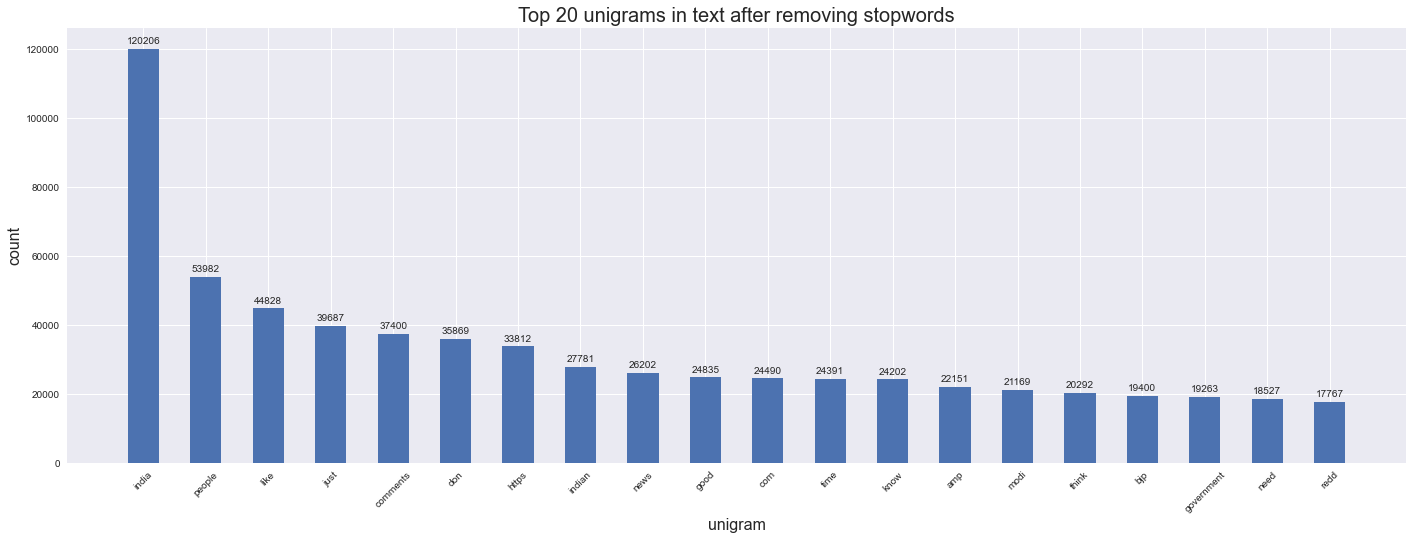

In [57]:
plot_n_gram(df_unigram, "unigram", "count_unigram", rotation=45)

#### Top 20 Bigrams after preprocessing

In [59]:
bigrams_count = get_n_ngrams(corpus=df_preprocessed.text, n=20, size=2)
df_bigram = pd.DataFrame(bigrams_count, columns = ['bigram' , 'count_bigram'])

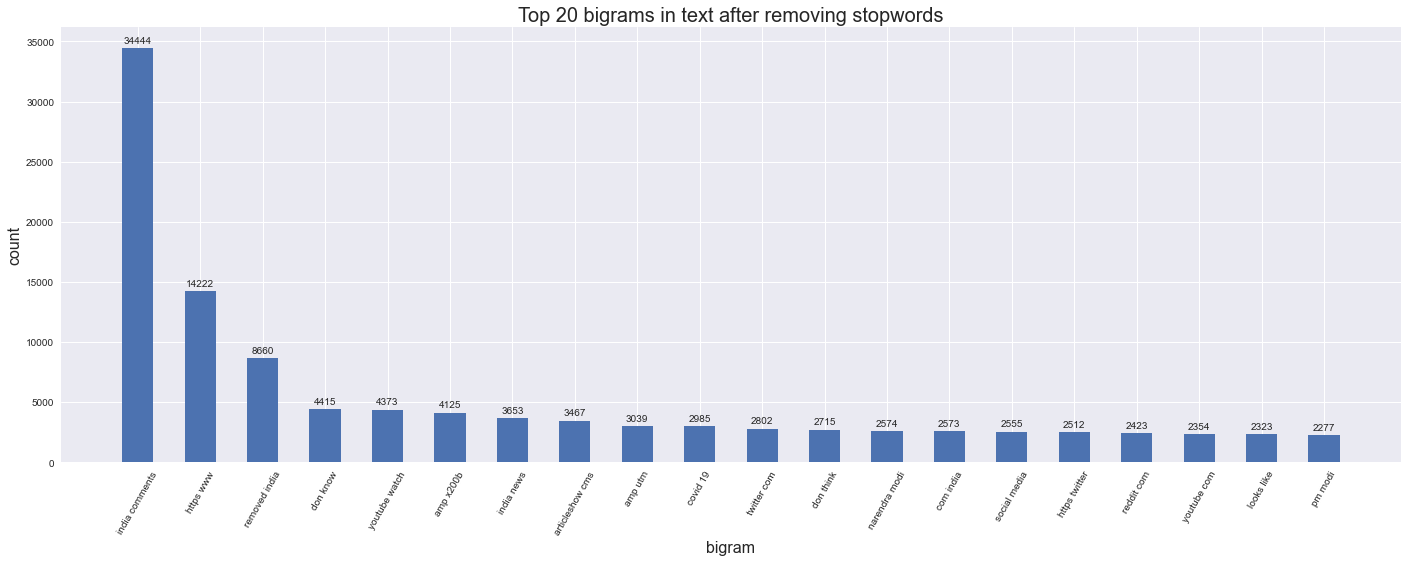

In [60]:
plot_n_gram(df_bigram, "bigram", "count_bigram", rotation=60)

#### Top 20 trigrams after removing stopwords

In [61]:
trigrams_count = get_n_ngrams(corpus=df_preprocessed.text, n=20, size=3)
df_trigram = pd.DataFrame(trigrams_count, columns = ['trigram' , 'count_trigram'])

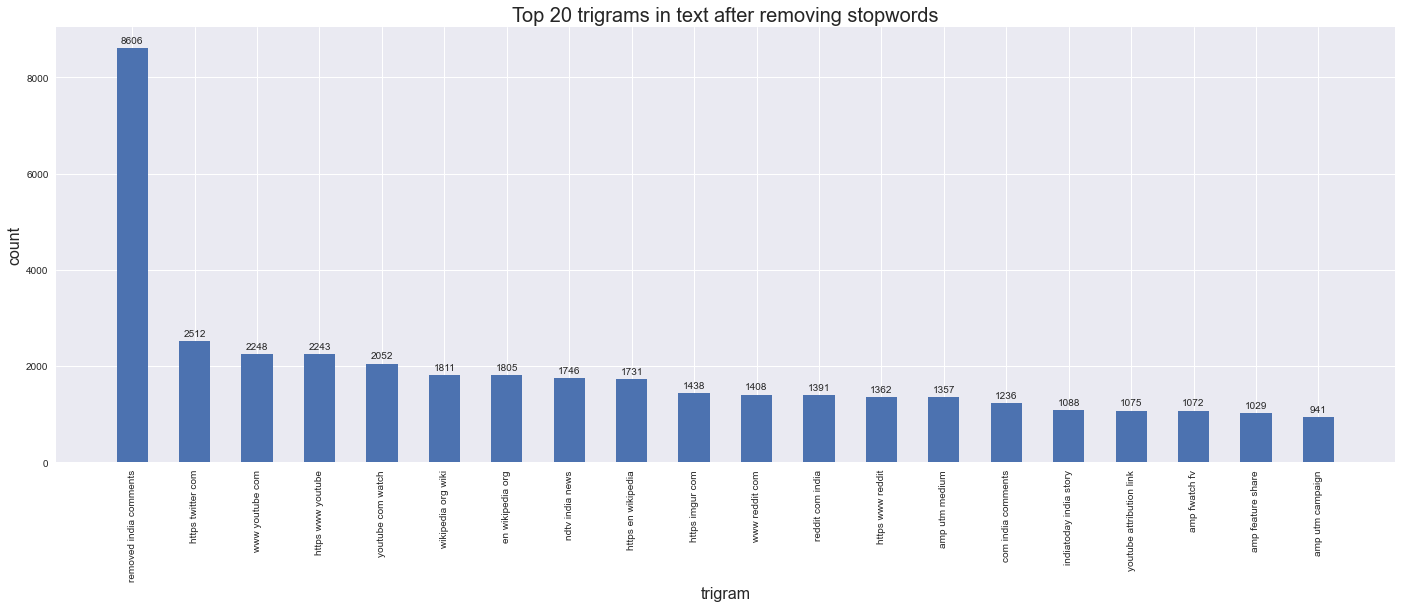

Wall time: 418 ms


In [62]:
%%time
plot_n_gram(df_trigram, "trigram", "count_trigram", rotation=90)

### 